In [1]:
import warnings
import nltk

warnings.filterwarnings('ignore')
nltk.download("all", quiet=True)


True

In [2]:
import random, os
import numpy as np
import torch

def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(42)


In [3]:
import datasets
import pandas as pd
from ast import literal_eval
datasets.disable_caching()

data_dir = '/kaggle/input/vispamdataset-v2/preprocessed/'

def load_data(data_dir):
    train_df = pd.read_csv(data_dir + 'train.csv', converters={'categories': literal_eval})
    dev_df = pd.read_csv(data_dir + 'dev.csv', converters={'categories': literal_eval})
    test_df = pd.read_csv(data_dir + 'test.csv', converters={'categories': literal_eval})
    
    train_dataset = datasets.Dataset.from_dict(train_df)
    dev_dataset = datasets.Dataset.from_dict(dev_df)
    test_dataset = datasets.Dataset.from_dict(test_df)
    dataset_dict = datasets.DatasetDict({'train': train_dataset, 'dev': dev_dataset, 'test': test_dataset})
    
    return dataset_dict

vispam_datasets = load_data(data_dir)


In [4]:
import numpy as np
from nltk.tokenize import word_tokenize

def tokenize(texts):
    max_len = 0
    tokenized_texts = []
    word2idx = {}
    
    word2idx['<pad>'] = 0
    word2idx['<unk>'] = 1
    
    idx = 2
    for sent in texts:
        tokenized_sent = word_tokenize(sent)
        tokenized_texts.append(tokenized_sent)
        
        for token in tokenized_sent:
            if token not in word2idx:
                word2idx[token] = idx
                idx += 1
                
        max_len = max(max_len, len(tokenized_sent))
        
    return tokenized_texts, word2idx, max_len


def encoding(tokenized_texts, word2idx, max_len=100):
    input_ids = []
    for tokenized_sent in tokenized_texts:
        if len(tokenized_sent) > max_len:
            tokenized_sent = tokenized_sent[:max_len]
            
        tokenized_sent += ['<pad>'] * (max_len - len(tokenized_sent))
        
        input_id = [word2idx.get(token, word2idx['<unk>']) for token in tokenized_sent]
        input_ids.append(input_id)
    
    return np.array(input_ids)


train_tokenized, word2idx, max_len = tokenize(vispam_datasets['train']['clean_comment'])
print("Number of words:", len(word2idx))
print("Max length of sentence:", max_len)


Number of words: 15359
Max length of sentence: 215


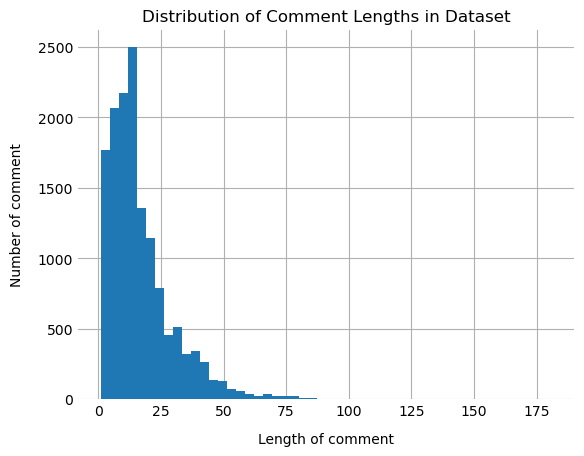

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.hist([len(s.split()) for s in vispam_datasets['train']['clean_comment']], bins=50)
ax.set_title('Distribution of Comment Lengths in Dataset', fontsize=12)
ax.set_xlabel("Length of comment", fontsize=10, labelpad=10)
ax.set_ylabel('Number of comment', fontsize=10, labelpad=10)
for pos in ['right', 'top', 'left', 'bottom']:
    ax.spines[pos].set_visible(False)
ax.tick_params(axis='both', which='both', length=0)
ax.grid()
ax.set_axisbelow(True)
plt.show()

In [6]:
categories = set(vispam_datasets['train']['category'] + vispam_datasets['dev']['category'] + vispam_datasets['test']['category'])
category2idx = {p:i for i, p in enumerate(categories)}
num_categories = len(category2idx)
print("Number of categories:", num_categories)
print("Categories:", categories)


Number of categories: 12
Categories: {'Điện Thoai - Máy Tính', 'Khác', 'Máy Ảnh', 'Nhà Cửa - Đời Sống', 'Điện Tử', 'Thời Trang', 'Sắc Đẹp', 'Sách', 'Phương Tiện', 'Giày Dép', 'Thể Thao', 'Đồ Chơi'}


In [7]:
def encode_mapping(examples):
    tokenized_texts = [word_tokenize(sent) for sent in examples['clean_comment']]
    input_ids = encoding(tokenized_texts, word2idx, max_len=100)
    category_ids = [category2idx[category] for category in examples['category']]
    
    return {'input_id': input_ids, "category_id": category_ids}


encoded_datasets = vispam_datasets.map(encode_mapping, batched=True)
encoded_datasets = encoded_datasets.remove_columns(vispam_datasets['train'].column_names[:-2])
encoded_datasets.set_format("torch")


  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [8]:
import torch
from tqdm import tqdm_notebook

def load_pretrained_vectors(word2idx, file_name):
    fin = open(file_name, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), d))
    embeddings[word2idx['<pad>']] = np.zeros((d,))
    
    count = 0
    for line in tqdm_notebook(fin):
        tokens = line.rstrip().split(' ')
        word = tokens[0]
        if word in word2idx:
            count += 1
            embeddings[word2idx[word]] = np.array(tokens[1:], dtype=np.float32)
            
    print(f"There are {count} / {len(word2idx)} pretrained vectors found.")
    
    return embeddings


embeddings = load_pretrained_vectors(word2idx, file_name="/kaggle/input/fasttext-pretrained-embeddings/cc.vi.300.vec")
embeddings = torch.tensor(embeddings)


0it [00:00, ?it/s]

There are 8584 / 15359 pretrained vectors found.


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MetaParamManager():
    def __init__(self):
        self.meta_em = {}

    def state_dict(self):
        return self.meta_em

    def register(self, name, param):
        self.meta_em[name] = param

        
class BasicWordEmbedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(BasicWordEmbedding, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
    def forward(self, input_ids):
        return self.embedding(input_ids).float()
    
    def load_embeddings(self, mode):
        if 'static' in mode:
            self.embedding.weight.data.copy_(embeddings)
            if 'non' not in mode:
                self.embedding.weight.data.requires_grad = False
                print('Loaded pretrained embeddings, weights are not trainable.')
            else:
                self.embedding.weight.data.requires_grad = True
                print('Loaded pretrained embeddings, weights are trainable.')
        elif mode == 'rand':
            print('Randomly initialized embeddings are used.')
        else:
            raise ValueError('Unexpected value of mode. Please choose from static, non-static, rand.')

            
class CustWordEmbedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim, meta_units, meta_param_manager):
        super(CustWordEmbedding, self).__init__()
        
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        for name, num_meta in meta_units:
            setattr(self, "num_" + name, num_meta)
            # Word Embedding transformation parameters
            setattr(self, name, nn.Embedding(num_meta, embedding_dim*embedding_dim))
            meta_param_manager.register("CustWordEmbedding." + name, getattr(self, name).weight)

    def forward(self, x, category_id):
        kwargs = {'category_id': category_id}
        x = self.embedding(x)
        r = None
        for name, idx in kwargs.items():
            v = getattr(self, name)(idx).view(x.shape[0], self.embedding_dim, self.embedding_dim)
            rv = torch.bmm(x, v)
            if (r is not None):
                r += rv
            else:
                r = rv
        # Residual addition
        x = x + torch.tanh(r)
        return x
    
    def load_embeddings(self, mode):
        if 'static' in mode:
            self.embedding.weight.data.copy_(embeddings)
            if 'non' not in mode:
                self.embedding.weight.data.requires_grad = False
                print('Loaded pretrained embeddings, weights are not trainable.')
            else:
                self.embedding.weight.data.requires_grad = True
                print('Loaded pretrained embeddings, weights are trainable.')
        elif mode == 'rand':
            print('Randomly initialized embeddings are used.')
        else:
            raise ValueError('Unexpected value of mode. Please choose from static, non-static, rand.')
    
    
class BasisCustWordEmbedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim, meta_units, meta_dim, key_query_size, num_bases, meta_param_manager):
        super(BasisCustWordEmbedding, self).__init__()
        
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        for name, num_meta in meta_units:
            setattr(self, "num_" + name, num_meta)
            # Word embedding transformation parameters
            setattr(self, name, nn.Embedding(num_meta, meta_dim))
            meta_param_manager.register("BasisCustWordEmbedding." + name, getattr(self, name).weight)
            
        self.P = nn.Sequential(
            # From MetaData to Query
            nn.Linear(meta_dim*len(meta_units), key_query_size),
            nn.Tanh(),
            # Calculate Weights of each Basis: Key & Query Inner-product
            nn.Linear(key_query_size, num_bases, bias=False),
            nn.Softmax(dim=1),
            # Weighted Sum of Bases
            nn.Linear(num_bases, embedding_dim*embedding_dim),
        )

    def forward(self, x, category_id):
        kwargs = {'category_id': category_id}
        x = self.embedding(x)
        query = torch.cat([getattr(self, name)(idx) for name, idx in kwargs.items()], dim=1)
        t = self.P(query).view(x.shape[0], self.embedding_dim, self.embedding_dim)
        r = torch.bmm(x, t)
        x = x + torch.tanh(r)
        return x
    
    def load_embeddings(self, mode):
        if 'static' in mode:
            self.embedding.weight.data.copy_(embeddings)
            if 'non' not in mode:
                self.embedding.weight.data.requires_grad = False
                print('Loaded pretrained embeddings, weights are not trainable.')
            else:
                self.embedding.weight.data.requires_grad = True
                print('Loaded pretrained embeddings, weights are trainable.')
        elif mode == 'rand':
            print('Randomly initialized embeddings are used.')
        else:
            raise ValueError('Unexpected value of mode. Please choose from static, non-static, rand.')
    
    
class TextCNN(nn.Module):
    def __init__(self, embedding_dim, kernel_sizes=[2, 3, 5], num_filters=32):
        super(TextCNN, self).__init__()
        
        self.conv = nn.ModuleList([nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters, kernel_size=k, stride=1) for k in kernel_sizes])
        
    def forward(self, h_embedding):
        x = h_embedding.permute(0, 2, 1)
        x = [F.relu(conv(x)) for conv in self.conv]
        x = [F.max_pool1d(c, kernel_size=c.shape[2]).squeeze(dim=2) for c in x]
        x = torch.cat(x, dim=1)
        return x
        
        
class BiLSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_size):
        super(BiLSTM, self).__init__()
        
        self.lstm = nn.LSTM(embedding_dim, hidden_size, bidirectional=True, batch_first=True)
    
    def forward(self, h_embedding):
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat((avg_pool, max_pool), 1)
        return conc
        
        
class BiGRU(nn.Module):
    def __init__(self, embedding_dim, hidden_size):
        super(BiGRU, self).__init__()
        
        self.gru = nn.GRU(embedding_dim, hidden_size, bidirectional=True, batch_first=True)
    
    def forward(self, h_embedding):
        h_gru, _ = self.gru(h_embedding)
        avg_pool = torch.mean(h_gru, 1)
        max_pool, _ = torch.max(h_gru, 1)
        conc = torch.cat((avg_pool, max_pool), 1)
        return conc

    
class BasicLinear(nn.Module):
    def __init__(self, state_size, num_classes):
        super(BasicLinear, self).__init__()
        self.W = nn.Linear(state_size, num_classes, bias=False)

    def forward(self, x):
        out = self.W(x)
        return out
    
    
class CustLinear(nn.Module):
    def __init__(self, meta_units, state_size, num_classes, meta_param_manager):
        super(CustLinear, self).__init__()
        
        self.state_size = state_size
        self.num_classes = num_classes
        
        for name, num_meta in meta_units:
            setattr(self, "num_" + name, num_meta)
            setattr(self, name, nn.Embedding(num_meta, state_size*num_classes))
            meta_param_manager.register("CustLinear." + name, getattr(self, name).weight)

    def forward(self, x, category_id):
        kwargs = {'category_id': category_id}
        W = torch.cat([getattr(self, name)(idx).view(x.shape[0], self.state_size, self.num_classes) for name, idx in kwargs.items()], dim=1)
        x = x.unsqueeze(dim=1).repeat(1, 1, len(kwargs))
        out = torch.bmm(x, W).squeeze(dim=1)
        return out
    
    
class BasisCustLinear(nn.Module):
    def __init__(self, meta_units, meta_dim, key_query_size, state_size, num_bases, num_classes, meta_param_manager):
        super(BasisCustLinear, self).__init__()
        
        self.state_size = state_size
        self.num_classes = num_classes
        
        for name, num_meta in meta_units:
            setattr(self, "num_" + name, num_meta)
            setattr(self, name, nn.Embedding(num_meta, meta_dim))
            meta_param_manager.register("BasisCustLinear." + name, getattr(self, name).weight)

        self.P = nn.Sequential(
            nn.Linear(meta_dim*len(meta_units), key_query_size),  # From MetaData to Query
            nn.Tanh(),
            # Calculate weights of each Basis: Key & Query Inner-product
            nn.Linear(key_query_size, num_bases, bias=False),
            nn.Softmax(dim=1),
            nn.Linear(num_bases, state_size * num_classes),  # Weighted Sum of Bases
        )
        
    def forward(self, x, category_id):
        kwargs = {'category_id': category_id}
        conc = torch.cat([getattr(self, name)(idx) for name, idx in kwargs.items()], dim=1)
        W = self.P(conc).view(x.shape[0], self.state_size, self.num_classes)
        out = torch.bmm(x.unsqueeze(dim=1), W).squeeze(dim=1)
        return out
    
    
class BasicBias(nn.Module):
    def __init__(self, num_classes):
        super(BasicBias, self).__init__()
        self.b = nn.Parameter(torch.zeros((1, num_classes)))

    def forward(self):
        return self.b
    
    
class CustBias(nn.Module):
    def __init__(self, meta_units, state_size, num_classes, meta_param_manager):
        super(CustBias, self).__init__()
        
        for name, num_meta in meta_units:
            setattr(self, "num_" + name, num_meta)
            setattr(self, name, nn.Embedding(num_meta, state_size))
            meta_param_manager.register("CustBias." + name, getattr(self, name).weight)
            
        self.Y = nn.Linear(state_size*len(meta_units), num_classes, bias=False)

    def forward(self, category_id):
        kwargs = {'category_id': category_id}
        conc = torch.cat([getattr(self, name)(idx) for name, idx in kwargs.items()], dim=1)
        out = self.Y(conc)
        return out
    
    
class BasisCustBias(nn.Module):
    def __init__(self, meta_units, meta_dim, state_size, key_query_size, num_bases, num_classes, meta_param_manager):
        super(BasisCustBias, self).__init__()
        
        for name, num_meta in meta_units:
            setattr(self, "num_" + name, num_meta)
            setattr(self, name, nn.Embedding(num_meta, meta_dim))
            meta_param_manager.register("BasisCustBias." + name, getattr(self, name).weight)

        self.P = nn.Sequential(
            # From MetaData to Query
            nn.Linear(meta_dim*len(meta_units), key_query_size),
            nn.Tanh(),
            # Calculate Weights of each Basis: Key & Query Inner-product
            nn.Linear(key_query_size, num_bases, bias=False),
            nn.Softmax(dim=1),
            # Weighted Sum of Bases
            nn.Linear(num_bases, state_size),
        )
        
        self.Y = nn.Linear(state_size, num_classes, bias=False)

    def forward(self, category_id):
        kwargs = {'category_id': category_id}
        conc = torch.cat([getattr(self, name)(idx) for name, idx in kwargs.items()], dim=1)
        out = self.Y(self.P(conc))
        return out
    

In [10]:
import torch
from torch import nn

class ViSpam_Classifier(nn.Module):
    def __init__(self, model_name, task, kernel_sizes=[2, 3, 5], num_filters=32, hidden_size=64, drop=0.5, spatial_dropout=True, mode='static'):
        super(ViSpam_Classifier, self).__init__()
        
        self.model_name = model_name
        name, model_type = model_name.split('_')
        
        assert name in ['TextCNN', 'BiLSTM', 'BiGRU']
        assert model_type in ['CustBias', 'CustLinear', 'CustWordEmbedding', 'BasisCustBias', 'BasisCustLinear', 'BasisCustWordEmbedding']
        
        self.task = task
        self.num_classes = 2 if task == 1 else 4
        self.vocab_size, self.embedding_dim = embeddings.shape
        self.kernel_sizes = kernel_sizes
        self.num_filters = num_filters
        self.hidden_size = hidden_size
        self.drop = drop
        self.spatial_dropout = spatial_dropout
        self.mode = mode
        
        self.meta_dim = 64
        self.key_query_size = 64
        self.num_bases = 4
        
        self.meta_param_manager = MetaParamManager()
        self.meta_units = [('category_id', num_categories)]
        
        # Word embedding
        if model_type == 'CustWordEmbedding':
            self.embedding = CustWordEmbedding(
                vocab_size=self.vocab_size,
                embedding_dim=self.embedding_dim,
                meta_units=self.meta_units,
                meta_param_manager=self.meta_param_manager
            )
        elif model_type == 'BasisCustWordEmbedding':
            self.embedding = BasisCustWordEmbedding(
                vocab_size=self.vocab_size,
                embedding_dim=self.embedding_dim,
                meta_units=self.meta_units,
                meta_dim=self.meta_dim,
                key_query_size=self.key_query_size,
                num_bases=self.num_bases,
                meta_param_manager=self.meta_param_manager
            )
        else:
            self.embedding = BasicWordEmbedding(vocab_size=self.vocab_size, embedding_dim=self.embedding_dim)
            
        self.embedding.load_embeddings(mode)
        
        # Spatial dropout
        if spatial_dropout:
            self.spatial_dropout1d = nn.Dropout2d(drop)
        else:
            self.dropout = nn.Dropout(drop)
        
        # Model
        if name == 'TextCNN':
            self.network = TextCNN(self.embedding_dim, kernel_sizes, num_filters)
            self.state_size = len(kernel_sizes)*num_filters
        elif name == 'BiLSTM':
            self.network = BiLSTM(self.embedding_dim, hidden_size)
            self.state_size = hidden_size*4
        else:
            self.network = BiGRU(self.embedding_dim, hidden_size)
            self.state_size = hidden_size*4
        
        # Linear
        if model_type == 'CustLinear':
            self.W = CustLinear(
                meta_units=self.meta_units,
                state_size=self.state_size,
                num_classes=self.num_classes,
                meta_param_manager=self.meta_param_manager
            )
        elif model_type == 'BasisCustLinear':
            self.W = BasisCustLinear(
                meta_units=self.meta_units,
                meta_dim=self.meta_dim,
                key_query_size=self.key_query_size,
                state_size=self.state_size,
                num_bases=self.num_bases,
                num_classes=self.num_classes,
                meta_param_manager=self.meta_param_manager
            )
        else:
            self.W = BasicLinear(state_size=self.state_size, num_classes=self.num_classes)
            
        # Bias
        if model_type == 'CustBias':
            self.bias = CustBias(
                meta_units=self.meta_units,
                state_size=self.state_size,
                num_classes=self.num_classes,
                meta_param_manager=self.meta_param_manager
            )
        elif model_type == 'BasisCustBias':
            self.bias = BasisCustBias(
                meta_units=self.meta_units,
                meta_dim=self.meta_dim,
                state_size=self.state_size,
                key_query_size=self.key_query_size,
                num_bases=self.num_bases,
                num_classes=self.num_classes,
                meta_param_manager=self.meta_param_manager
            )
        else:
            self.bias = BasicBias(self.num_classes)
            
    def forward(self, input_ids, category_id):
        batch_size, sequence_length = input_ids.shape
        
        if 'CustWordEmbedding' in self.model_name:
            h_embedding = self.embedding(input_ids, category_id)
        else:
            h_embedding = self.embedding(input_ids)
        
        if self.spatial_dropout:
            h_embedding = h_embedding.permute(0, 2, 1)
            h_embedding = self.spatial_dropout1d(h_embedding)
            h_embedding = h_embedding.permute(0, 2, 1)
        else:
            h_embedding = self.dropout(h_embedding)
        
        output_net = self.network(h_embedding)
        
        if 'CustLinear' in self.model_name:
            x = self.W(output_net, category_id)
        else:
            x = self.W(output_net)
        
        if 'CustBias' in self.model_name:
            x += self.bias(category_id)
        else:
            x += self.bias()
        
        return x
    

In [11]:
import torch
import numpy as np

class EarlyStopping:
    
    def __init__(self, patience=5, verbose=True, delta=0, path='checkpoint.pth'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        
    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
            
    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
            
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


In [12]:
import os
import json
import numpy as np
from scipy import interpolate
from pathlib import Path
import torch
from torch import nn
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot, plot

def train_step(model, criterion, optimizer, train_dataloader, task):
    model.train()
    losses = []
    correct = 0
    
    label_column = 'label' if task == 1 else 'spam_label'
    
    for data in train_dataloader:
        input_ids = data['input_id'].to(device)
        category_id = data['category_id'].to(device)
        labels = data[label_column].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, category_id=category_id)
        
        loss = criterion(outputs, labels)
        pred = torch.max(outputs, dim=1)[1]
        
        correct += torch.sum(pred == labels)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

    accuracy = correct.double().cpu().data.numpy()/len(train_dataloader.dataset)
    loss = np.mean(losses)

    return accuracy, loss


def validation_step(model, criterion, dataloader, task):
    model.eval()
    losses = []
    correct = 0
    
    label_column = 'label' if task == 1 else 'spam_label'
    
    with torch.no_grad():
        for data in dataloader:
            input_ids = data['input_id'].to(device)
            category_id = data['category_id'].to(device)
            labels = data[label_column].to(device)

            outputs = model(input_ids=input_ids, category_id=category_id)
            
            loss = criterion(outputs, labels)
            pred = torch.max(outputs, dim=1)[1]
            
            correct += torch.sum(pred == labels)
            losses.append(loss.item())

    accuracy = correct.double().cpu().data.numpy()/len(dataloader.dataset)
    loss = np.mean(losses)

    return accuracy, loss


def train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs, early_stopping, task):
    Path(model.model_name).mkdir(parents=True, exist_ok=True)
    
    if early_stopping:
        path_checkpoint = os.path.join(model.model_name, f"{model.model_name}_checkpoint_({task}).pth")
        early_stopping.path = path_checkpoint
    
    best_accuracy = 0
    best_model_path = os.path.join(model.model_name, f"{model.model_name}_best_model_({task}).pth")
    last_model_path = os.path.join(model.model_name, f"{model.model_name}_last_model_({task}).pth")
    history = {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []}

    for epoch in range(epochs):
        print("Epoch {}/{}".format(epoch+1, epochs))
        print("-"*50)
        
        train_accuracy, train_loss = train_step(model, criterion, optimizer, train_dataloader, task)
        val_accuracy, val_loss = validation_step(model, criterion, val_dataloader, task)
        
        history['train_acc'].append(train_accuracy)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_accuracy)
        history['val_loss'].append(val_loss)
        
        print("Train Accuracy: {:.4f} - Train Loss: {:.4f}".format(train_accuracy, train_loss))
        print("Val Accuracy: {:.4f} - Val Loss: {:.4f}".format(val_accuracy, val_loss))
        
        if val_accuracy > best_accuracy:
            torch.save(model.state_dict(), best_model_path)
            best_accuracy = val_accuracy
        
        if epoch + 1 == epochs:
            torch.save(model.state_dict(), last_model_path)
            
        if early_stopping:
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                torch.save(model.state_dict(), last_model_path)
                print("Early stopping.")
                break
    
    history_path = os.path.join(model.model_name, f"{model.model_name}_history_({task}).json")
    with open(history_path, 'w') as f:
        json.dump(history, f)
        
    # with open(history_path) as f:
    #     history = json.load(f)
    
    return history


def test(model, dataloader, task):
    model.eval()
    predicts = []
    predict_probs = []
    true_labels = []
    
    label_column = 'label' if task == 1 else 'spam_label'
    
    for data in tqdm(dataloader):
        input_ids = data['input_id'].to(device)
        category_id = data['category_id'].to(device)
        labels = data[label_column].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, category_id=category_id)
  
        pred = torch.max(outputs, dim=1)[1]
        predicts.extend(pred.cpu().data.numpy())
        predict_probs.extend(outputs.cpu().data.numpy())
        true_labels.extend(labels.cpu().data.numpy())
        
    return true_labels, predicts


def evaluate(true_labels, predicts):
    test_accuracy = accuracy_score(true_labels, predicts)
    test_precision = precision_score(true_labels, predicts, average='macro')
    test_recall = recall_score(true_labels, predicts, average='macro')
    test_f1 = f1_score(true_labels, predicts, average='macro')
    test_cm = confusion_matrix(true_labels, predicts)

    print("Accuracy: {:.4f}".format(test_accuracy))
    print("Precision: {:.4f}".format(test_precision))
    print("Recall: {:.4f}".format(test_recall))
    print("F1-score: {:.4f}".format(test_f1))
    print("Confusion matrix:\n", test_cm)
    print(classification_report(true_labels, predicts, digits=4))
    
    return test_cm


def save_visualization_history(history, model_name, task):
    colors = plt.get_cmap('tab10').colors

    epochs = np.arange(1, len(history['train_loss']) + 1)
    xnew = np.linspace(epochs[0], epochs[-1], 300)
    
    train_loss_smooth = interpolate.interp1d(epochs, history['train_loss'], kind='linear')(xnew)
    val_loss_smooth = interpolate.interp1d(epochs, history['val_loss'], kind='linear')(xnew)

    fig, ax = plt.subplots()
    ax.plot(xnew, train_loss_smooth, color=colors[0], linewidth=3, label='Training Loss')
    ax.plot(xnew, val_loss_smooth, color=colors[1], linewidth=3, label='Validation Loss')
    ax.set_title('Training and Validation Loss', fontsize=12)
    ax.set_xlabel('Epoch', fontsize=10, labelpad=10)
    ax.set_ylabel('Loss', fontsize=10, labelpad=10)
    ax.tick_params(axis='both', which='both', length=0)
    ax.grid(axis='y')
    for pos in ['right', 'top', 'left', 'bottom']:
        ax.spines[pos].set_visible(False)
    ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), frameon=False, prop={'size': 10})
    
    file_name = os.path.join(model_name, f"{model_name}_loss_visualization_({task}).png")
    fig.savefig(file_name, dpi=300, bbox_inches='tight')
    plt.close(fig)
    
    train_acc_smooth = interpolate.interp1d(epochs, history['train_acc'], kind='linear')(xnew)
    val_acc_smooth = interpolate.interp1d(epochs, history['val_acc'], kind='linear')(xnew)

    fig, ax = plt.subplots()
    ax.plot(xnew, train_acc_smooth, color=colors[2], linewidth=3, label='Training Accuracy')
    ax.plot(xnew, val_acc_smooth, color=colors[4], linewidth=3, label='Validation Accuracy')
    ax.set_title('Training and Validation Accuracy', fontsize=12)
    ax.set_xlabel('Epoch', fontsize=10, labelpad=10)
    ax.set_ylabel('Accuracy', fontsize=10, labelpad=10)
    ax.tick_params(axis='both', which='both', length=0)
    ax.grid(axis='y')
    for pos in ['right', 'top', 'left', 'bottom']:
        ax.spines[pos].set_visible(False)
    ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), frameon=False, prop={'size': 10})
    
    file_name = os.path.join(model_name, f"{model_name}_accuracy_visualization_({task}).png")
    fig.savefig(file_name, dpi=300, bbox_inches='tight')
    plt.close(fig)


def plotting_history(history):
    assert len(history['train_loss']) == len(history['val_loss'])
    assert len(history['train_acc']) == len(history['val_acc'])
    
    fig = make_subplots(rows=1, cols=2, subplot_titles=("Loss", "Accuracy"), shared_yaxes=False, shared_xaxes=False, vertical_spacing=0.1, horizontal_spacing=0.05)
    
    num_epochs = len(history['train_loss'])
    epoch_labels = list(range(1, num_epochs+1))

    fig.add_trace(go.Scatter(x=epoch_labels, y=history['train_loss'], name='train_loss', legendgroup='1'), row=1, col=1)
    fig.add_trace(go.Scatter(x=epoch_labels, y=history['val_loss'], name='val_loss', legendgroup='1'), row=1, col=1)
    fig.add_trace(go.Scatter(x=epoch_labels, y=history['train_acc'], name='train_accuracy', legendgroup='2'), row=1, col=2)
    fig.add_trace(go.Scatter(x=epoch_labels, y=history['val_acc'], name='val_accuracy', legendgroup='2'), row=1, col=2)

    fig.update_layout(legend=dict(orientation="h", xanchor="center", x=0.5), showlegend=True)
    fig.show()
    
    
def plotting_confusion_matrix(confusion_matrix, task):
    if task == 1:
        labels = ['no-spam', 'spam']
        font_size = 30
    else:
        labels = ['no-spam', 'spam-1', 'spam-2', 'spam-3']
        font_size = 22
        
    plt.figure(dpi=100)
    df_cm = pd.DataFrame(confusion_matrix, index=labels, columns=labels)
    sns.heatmap(df_cm, annot=True, cmap="Greys", fmt="g", cbar=True, annot_kws={"size": font_size})
    plt.show()


In [13]:
import torch
import numpy as np
from sklearn.utils import class_weight

labels = encoded_datasets['train']['label']
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels.numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float)

spam_labels = encoded_datasets['train']['spam_label']
spam_class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(spam_labels), y=spam_labels.numpy())
spam_class_weights = torch.tensor(spam_class_weights, dtype=torch.float)

class_weights, spam_class_weights


(tensor([0.6797, 1.8909]), tensor([ 0.3399, 16.9242,  3.2375,  1.4499]))

In [14]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [15]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(encoded_datasets['train'], shuffle=True, batch_size=256)
val_dataloader = DataLoader(encoded_datasets['dev'], batch_size=256)
test_dataloader = DataLoader(encoded_datasets['test'], batch_size=256)


# TextCNN - Cust Bias

## Task 1

In [16]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="TextCNN_CustBias", task=1).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=1)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.7239 - Train Loss: 0.5920
Val Accuracy: 0.8093 - Val Loss: 0.4965
Validation loss decreased (inf --> 0.496468). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.8123 - Train Loss: 0.4411
Val Accuracy: 0.8301 - Val Loss: 0.4611
Validation loss decreased (0.496468 --> 0.461104). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.8440 - Train Loss: 0.3656
Val Accuracy: 0.8326 - Val Loss: 0.4608
Validation loss decreased (0.461104 --> 0.460794). Saving model ...
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.8748 - Train Loss: 0.3057
Val Accuracy: 0.8351 - Val Loss: 0.4674
EarlyStopping counter: 1 out of 10
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.8945 - Train Loss: 0.2597
Val Accuracy: 0.840

In [17]:
save_visualization_history(history, 'TextCNN_CustBias', task=1)
plotting_history(history)


In [18]:
import os
import torch

model_name = "TextCNN_CustBias"
model_path = os.path.join(model_name, f"{model_name}_best_model_(1).pth")
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8524
Precision: 0.8219
Recall: 0.7836
F1-score: 0.7993
Confusion matrix:
 [[2708  203]
 [ 382  670]]
              precision    recall  f1-score   support

           0     0.8764    0.9303    0.9025      2911
           1     0.7675    0.6369    0.6961      1052

    accuracy                         0.8524      3963
   macro avg     0.8219    0.7836    0.7993      3963
weighted avg     0.8475    0.8524    0.8477      3963



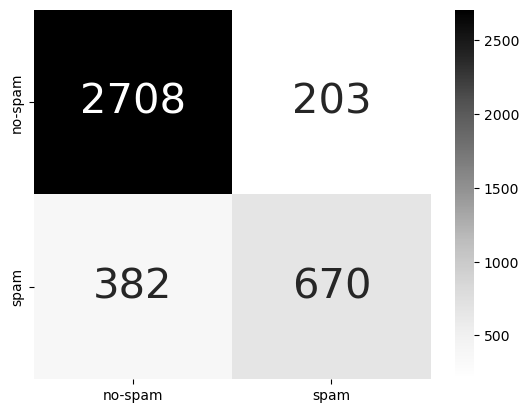

In [19]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [20]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="TextCNN_CustBias", task=2).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=2)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.4009 - Train Loss: 1.2120
Val Accuracy: 0.5532 - Val Loss: 1.1441
Validation loss decreased (inf --> 1.144129). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.6269 - Train Loss: 0.8850
Val Accuracy: 0.6161 - Val Loss: 1.0027
Validation loss decreased (1.144129 --> 1.002711). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.6999 - Train Loss: 0.6936
Val Accuracy: 0.6992 - Val Loss: 0.9365
Validation loss decreased (1.002711 --> 0.936507). Saving model ...
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.7447 - Train Loss: 0.5791
Val Accuracy: 0.7294 - Val Loss: 0.9048
Validation loss decreased (0.936507 --> 0.904805). Saving model ...
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.7716 - Train

In [21]:
save_visualization_history(history, 'TextCNN_CustBias', task=2)
plotting_history(history)


In [22]:
import os
import torch

model_name = "TextCNN_CustBias"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8055
Precision: 0.6248
Recall: 0.6803
F1-score: 0.6428
Confusion matrix:
 [[2505   30  259  117]
 [  17   30    4    3]
 [  96    1  197   15]
 [ 186    8   35  460]]
              precision    recall  f1-score   support

           0     0.8934    0.8605    0.8766      2911
           1     0.4348    0.5556    0.4878        54
           2     0.3980    0.6375    0.4900       309
           3     0.7731    0.6676    0.7165       689

    accuracy                         0.8055      3963
   macro avg     0.6248    0.6803    0.6428      3963
weighted avg     0.8276    0.8055    0.8134      3963



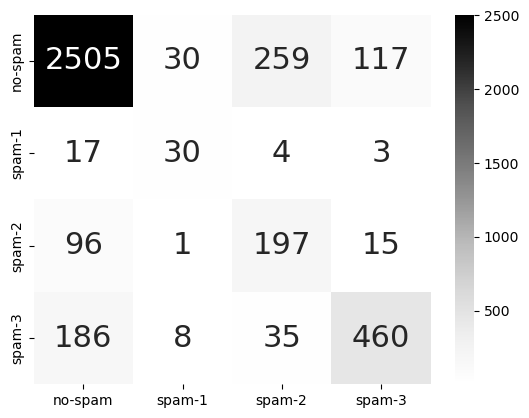

In [23]:
plotting_confusion_matrix(test_cm, task=2)


# TextCNN - Basis Cust Bias

## Task 1

In [24]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="TextCNN_BasisCustBias", task=1).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=1)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.7218 - Train Loss: 0.6137
Val Accuracy: 0.8024 - Val Loss: 0.5000
Validation loss decreased (inf --> 0.500017). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.8028 - Train Loss: 0.4470
Val Accuracy: 0.8263 - Val Loss: 0.4566
Validation loss decreased (0.500017 --> 0.456600). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.8405 - Train Loss: 0.3757
Val Accuracy: 0.8213 - Val Loss: 0.4528
Validation loss decreased (0.456600 --> 0.452840). Saving model ...
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.8684 - Train Loss: 0.3138
Val Accuracy: 0.8345 - Val Loss: 0.4795
EarlyStopping counter: 1 out of 10
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.8946 - Train Loss: 0.2592
Val Accuracy: 0.833

In [25]:
save_visualization_history(history, 'TextCNN_BasisCustBias', task=1)
plotting_history(history)


In [26]:
import os
import torch

model_name = "TextCNN_BasisCustBias"
model_path = os.path.join(model_name, f"{model_name}_best_model_(1).pth")
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8436
Precision: 0.8011
Recall: 0.7921
F1-score: 0.7964
Confusion matrix:
 [[2625  286]
 [ 334  718]]
              precision    recall  f1-score   support

           0     0.8871    0.9018    0.8944      2911
           1     0.7151    0.6825    0.6984      1052

    accuracy                         0.8436      3963
   macro avg     0.8011    0.7921    0.7964      3963
weighted avg     0.8415    0.8436    0.8424      3963



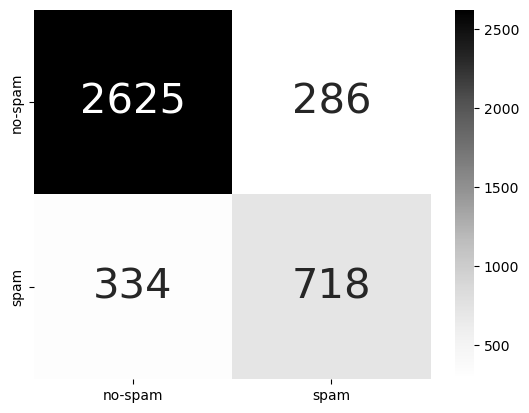

In [27]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [28]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="TextCNN_BasisCustBias", task=2).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=2)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.4762 - Train Loss: 1.2108
Val Accuracy: 0.5299 - Val Loss: 1.1330
Validation loss decreased (inf --> 1.133041). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.6175 - Train Loss: 0.8708
Val Accuracy: 0.6853 - Val Loss: 0.9939
Validation loss decreased (1.133041 --> 0.993924). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.6929 - Train Loss: 0.6917
Val Accuracy: 0.7004 - Val Loss: 0.9319
Validation loss decreased (0.993924 --> 0.931895). Saving model ...
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.7360 - Train Loss: 0.5709
Val Accuracy: 0.7432 - Val Loss: 0.9578
EarlyStopping counter: 1 out of 10
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.7683 - Train Loss: 0.4827
Val Accuracy: 0.767

In [29]:
save_visualization_history(history, 'TextCNN_BasisCustBias', task=2)
plotting_history(history)


In [30]:
import os
import torch

model_name = "TextCNN_BasisCustBias"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8047
Precision: 0.6173
Recall: 0.6741
F1-score: 0.6377
Confusion matrix:
 [[2497   33  248  133]
 [  18   29    4    3]
 [ 101    1  190   17]
 [ 176    6   34  473]]
              precision    recall  f1-score   support

           0     0.8943    0.8578    0.8757      2911
           1     0.4203    0.5370    0.4715        54
           2     0.3992    0.6149    0.4841       309
           3     0.7556    0.6865    0.7194       689

    accuracy                         0.8047      3963
   macro avg     0.6173    0.6741    0.6377      3963
weighted avg     0.8251    0.8047    0.8125      3963



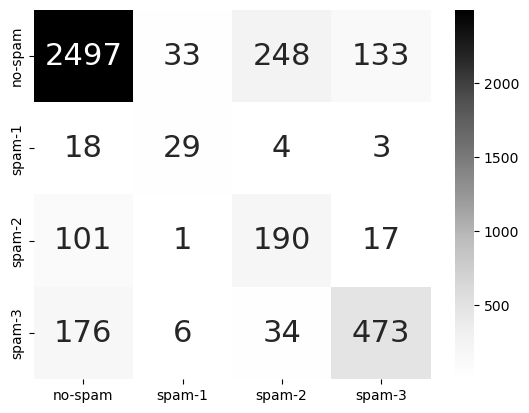

In [31]:
plotting_confusion_matrix(test_cm, task=2)


# TextCNN - Cust Linear

## Task 1

In [32]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="TextCNN_CustLinear", task=1).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=1)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.6523 - Train Loss: 0.7205
Val Accuracy: 0.7508 - Val Loss: 0.5774
Validation loss decreased (inf --> 0.577367). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.7765 - Train Loss: 0.5020
Val Accuracy: 0.7980 - Val Loss: 0.5296
Validation loss decreased (0.577367 --> 0.529600). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.8278 - Train Loss: 0.4138
Val Accuracy: 0.8087 - Val Loss: 0.4983
Validation loss decreased (0.529600 --> 0.498299). Saving model ...
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.8681 - Train Loss: 0.3290
Val Accuracy: 0.8213 - Val Loss: 0.4912
Validation loss decreased (0.498299 --> 0.491189). Saving model ...
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.8990 - Train

In [33]:
save_visualization_history(history, 'TextCNN_CustLinear', task=1)
plotting_history(history)


In [34]:
import os
import torch

model_name = "TextCNN_CustLinear"
model_path = os.path.join(model_name, f"{model_name}_best_model_(1).pth")
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8186
Precision: 0.7701
Recall: 0.7493
F1-score: 0.7584
Confusion matrix:
 [[2611  300]
 [ 419  633]]
              precision    recall  f1-score   support

           0     0.8617    0.8969    0.8790      2911
           1     0.6785    0.6017    0.6378      1052

    accuracy                         0.8186      3963
   macro avg     0.7701    0.7493    0.7584      3963
weighted avg     0.8131    0.8186    0.8150      3963



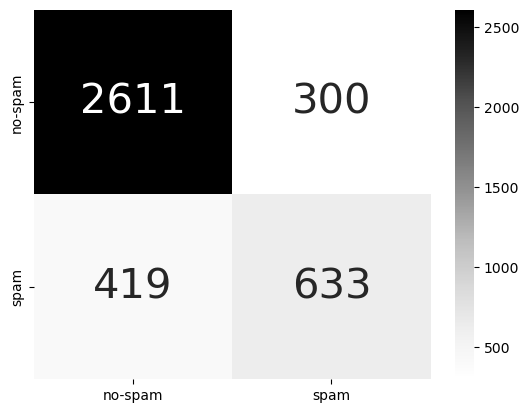

In [35]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [36]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="TextCNN_CustLinear", task=2).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=2)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.3682 - Train Loss: 1.4391
Val Accuracy: 0.4141 - Val Loss: 1.3046
Validation loss decreased (inf --> 1.304563). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.5391 - Train Loss: 0.9944
Val Accuracy: 0.5362 - Val Loss: 1.2039
Validation loss decreased (1.304563 --> 1.203925). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.6504 - Train Loss: 0.7886
Val Accuracy: 0.6287 - Val Loss: 1.1511
Validation loss decreased (1.203925 --> 1.151095). Saving model ...
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.7190 - Train Loss: 0.6245
Val Accuracy: 0.6746 - Val Loss: 1.1031
Validation loss decreased (1.151095 --> 1.103132). Saving model ...
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.7620 - Train

In [37]:
save_visualization_history(history, 'TextCNN_CustLinear', task=2)
plotting_history(history)


In [38]:
import os
import torch

model_name = "TextCNN_CustLinear"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.7933
Precision: 0.5814
Recall: 0.6153
F1-score: 0.5922
Confusion matrix:
 [[2502   35  245  129]
 [  21   22    9    2]
 [ 127    3  165   14]
 [ 190    8   36  455]]
              precision    recall  f1-score   support

           0     0.8810    0.8595    0.8701      2911
           1     0.3235    0.4074    0.3607        54
           2     0.3626    0.5340    0.4319       309
           3     0.7583    0.6604    0.7060       689

    accuracy                         0.7933      3963
   macro avg     0.5814    0.6153    0.5922      3963
weighted avg     0.8116    0.7933    0.8005      3963



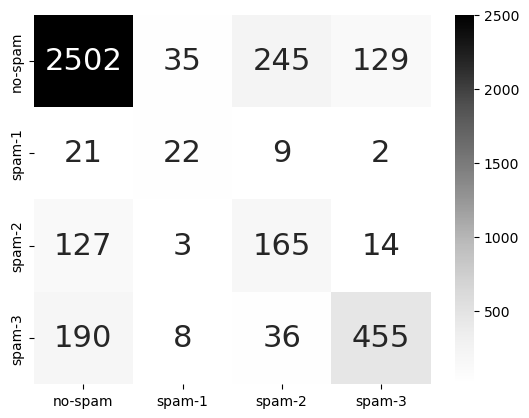

In [39]:
plotting_confusion_matrix(test_cm, task=2)


# TextCNN - Basis Cust Linear

## Task 1

In [40]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="TextCNN_BasisCustLinear", task=1).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=1)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.7565 - Train Loss: 0.5560
Val Accuracy: 0.8213 - Val Loss: 0.4740
Validation loss decreased (inf --> 0.474019). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.8122 - Train Loss: 0.4261
Val Accuracy: 0.8458 - Val Loss: 0.4663
Validation loss decreased (0.474019 --> 0.466330). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.8472 - Train Loss: 0.3569
Val Accuracy: 0.8389 - Val Loss: 0.4354
Validation loss decreased (0.466330 --> 0.435426). Saving model ...
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.8752 - Train Loss: 0.2986
Val Accuracy: 0.8263 - Val Loss: 0.4225
Validation loss decreased (0.435426 --> 0.422521). Saving model ...
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.9001 - Train

In [41]:
save_visualization_history(history, 'TextCNN_BasisCustLinear', task=1)
plotting_history(history)


In [42]:
import os
import torch

model_name = "TextCNN_BasisCustLinear"
model_path = os.path.join(model_name, f"{model_name}_best_model_(1).pth")
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8438
Precision: 0.8003
Recall: 0.7972
F1-score: 0.7987
Confusion matrix:
 [[2610  301]
 [ 318  734]]
              precision    recall  f1-score   support

           0     0.8914    0.8966    0.8940      2911
           1     0.7092    0.6977    0.7034      1052

    accuracy                         0.8438      3963
   macro avg     0.8003    0.7972    0.7987      3963
weighted avg     0.8430    0.8438    0.8434      3963



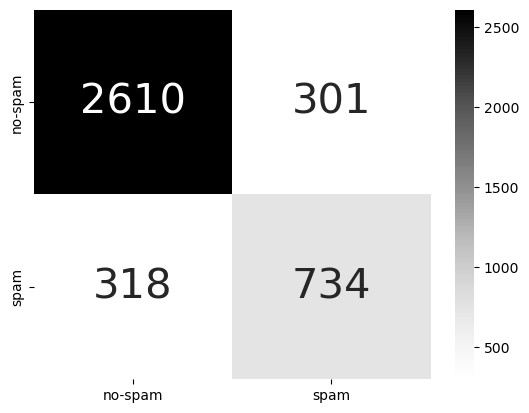

In [43]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [44]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="TextCNN_BasisCustLinear", task=2).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=2)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.5073 - Train Loss: 1.1228
Val Accuracy: 0.6834 - Val Loss: 1.0489
Validation loss decreased (inf --> 1.048915). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.6639 - Train Loss: 0.7850
Val Accuracy: 0.7143 - Val Loss: 0.9629
Validation loss decreased (1.048915 --> 0.962888). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.7293 - Train Loss: 0.6198
Val Accuracy: 0.7351 - Val Loss: 0.8938
Validation loss decreased (0.962888 --> 0.893838). Saving model ...
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.7646 - Train Loss: 0.4926
Val Accuracy: 0.7948 - Val Loss: 0.9379
EarlyStopping counter: 1 out of 10
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.8105 - Train Loss: 0.4006
Val Accuracy: 0.774

In [45]:
save_visualization_history(history, 'TextCNN_BasisCustLinear', task=2)
plotting_history(history)


In [46]:
import os
import torch

model_name = "TextCNN_BasisCustLinear"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8244
Precision: 0.6513
Recall: 0.6781
F1-score: 0.6596
Confusion matrix:
 [[2583   24  200  104]
 [  20   29    2    3]
 [ 109    1  189   10]
 [ 182    8   33  466]]
              precision    recall  f1-score   support

           0     0.8925    0.8873    0.8899      2911
           1     0.4677    0.5370    0.5000        54
           2     0.4458    0.6117    0.5157       309
           3     0.7993    0.6763    0.7327       689

    accuracy                         0.8244      3963
   macro avg     0.6513    0.6781    0.6596      3963
weighted avg     0.8357    0.8244    0.8281      3963



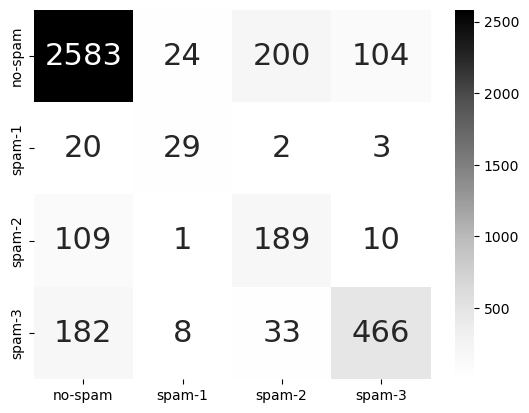

In [47]:
plotting_confusion_matrix(test_cm, task=2)


# TextCNN - Cust Word Embedding

## Task 1

In [48]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="TextCNN_CustWordEmbedding", task=1).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=1)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.6791 - Train Loss: 0.6296
Val Accuracy: 0.8118 - Val Loss: 0.5554
Validation loss decreased (inf --> 0.555445). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.7898 - Train Loss: 0.4901
Val Accuracy: 0.8238 - Val Loss: 0.4989
Validation loss decreased (0.555445 --> 0.498880). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.8424 - Train Loss: 0.3775
Val Accuracy: 0.8288 - Val Loss: 0.5303
EarlyStopping counter: 1 out of 10
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.8778 - Train Loss: 0.2991
Val Accuracy: 0.8301 - Val Loss: 0.5140
EarlyStopping counter: 2 out of 10
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.9110 - Train Loss: 0.2237
Val Accuracy: 0.8269 - Val Loss: 0.5539
EarlyStoppin

In [49]:
save_visualization_history(history, 'TextCNN_CustWordEmbedding', task=1)
plotting_history(history)


In [50]:
import os
import torch

model_name = "TextCNN_CustWordEmbedding"
model_path = os.path.join(model_name, f"{model_name}_best_model_(1).pth")
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8234
Precision: 0.7814
Recall: 0.7423
F1-score: 0.7575
Confusion matrix:
 [[2664  247]
 [ 453  599]]
              precision    recall  f1-score   support

           0     0.8547    0.9151    0.8839      2911
           1     0.7080    0.5694    0.6312      1052

    accuracy                         0.8234      3963
   macro avg     0.7814    0.7423    0.7575      3963
weighted avg     0.8157    0.8234    0.8168      3963



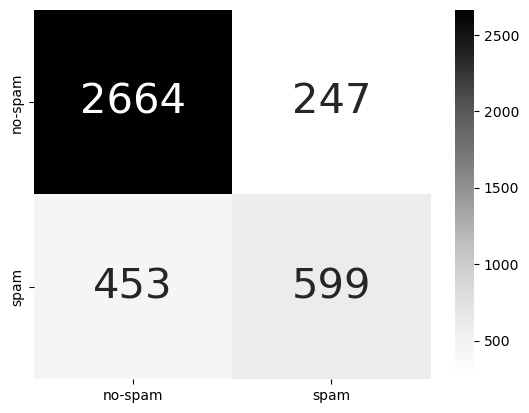

In [51]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [52]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="TextCNN_CustWordEmbedding", task=2).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=2)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.3872 - Train Loss: 1.2376
Val Accuracy: 0.4122 - Val Loss: 1.1806
Validation loss decreased (inf --> 1.180604). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.5700 - Train Loss: 0.9422
Val Accuracy: 0.5941 - Val Loss: 1.0605
Validation loss decreased (1.180604 --> 1.060538). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.6803 - Train Loss: 0.7021
Val Accuracy: 0.5872 - Val Loss: 1.0484
Validation loss decreased (1.060538 --> 1.048355). Saving model ...
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.7464 - Train Loss: 0.4964
Val Accuracy: 0.6847 - Val Loss: 1.0643
EarlyStopping counter: 1 out of 10
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.8071 - Train Loss: 0.3637
Val Accuracy: 0.714

In [53]:
save_visualization_history(history, 'TextCNN_CustWordEmbedding', task=2)
plotting_history(history)


In [54]:
import os
import torch

model_name = "TextCNN_CustWordEmbedding"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.7893
Precision: 0.5785
Recall: 0.5939
F1-score: 0.5766
Confusion matrix:
 [[2564   38  206  103]
 [  22   23    7    2]
 [ 140    0  159   10]
 [ 240   14   53  382]]
              precision    recall  f1-score   support

           0     0.8645    0.8808    0.8726      2911
           1     0.3067    0.4259    0.3566        54
           2     0.3741    0.5146    0.4332       309
           3     0.7686    0.5544    0.6442       689

    accuracy                         0.7893      3963
   macro avg     0.5785    0.5939    0.5766      3963
weighted avg     0.8020    0.7893    0.7916      3963



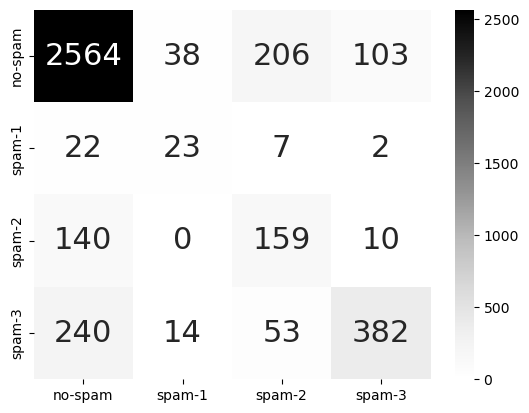

In [55]:
plotting_confusion_matrix(test_cm, task=2)


# TextCNN - Basis Cust Word Embedding

## Task 1

In [56]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="TextCNN_BasisCustWordEmbedding", task=1).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=1)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.7670 - Train Loss: 0.5499
Val Accuracy: 0.8433 - Val Loss: 0.5124
Validation loss decreased (inf --> 0.512395). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.8332 - Train Loss: 0.4033
Val Accuracy: 0.8339 - Val Loss: 0.4485
Validation loss decreased (0.512395 --> 0.448497). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.8792 - Train Loss: 0.2991
Val Accuracy: 0.8414 - Val Loss: 0.4736
EarlyStopping counter: 1 out of 10
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.9151 - Train Loss: 0.2180
Val Accuracy: 0.8263 - Val Loss: 0.5291
EarlyStopping counter: 2 out of 10
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.9359 - Train Loss: 0.1681
Val Accuracy: 0.8118 - Val Loss: 0.5815
EarlyStoppin

In [57]:
save_visualization_history(history, 'TextCNN_BasisCustWordEmbedding', task=1)
plotting_history(history)


In [58]:
import os
import torch

model_name = "TextCNN_BasisCustWordEmbedding"
model_path = os.path.join(model_name, f"{model_name}_best_model_(1).pth")
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8362
Precision: 0.8052
Recall: 0.7510
F1-score: 0.7709
Confusion matrix:
 [[2715  196]
 [ 453  599]]
              precision    recall  f1-score   support

           0     0.8570    0.9327    0.8932      2911
           1     0.7535    0.5694    0.6486      1052

    accuracy                         0.8362      3963
   macro avg     0.8052    0.7510    0.7709      3963
weighted avg     0.8295    0.8362    0.8283      3963



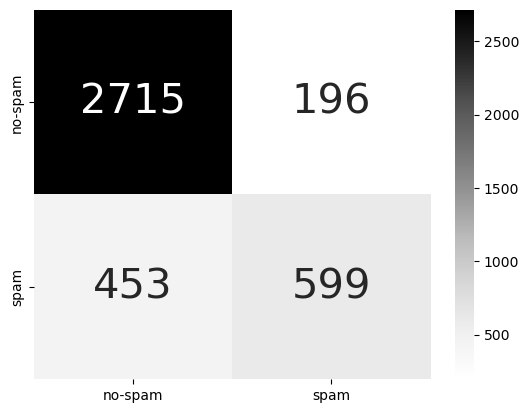

In [59]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [60]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="TextCNN_BasisCustWordEmbedding", task=2).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=2)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.5532 - Train Loss: 1.0546
Val Accuracy: 0.6482 - Val Loss: 0.9984
Validation loss decreased (inf --> 0.998415). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.7021 - Train Loss: 0.7375
Val Accuracy: 0.7168 - Val Loss: 0.8728
Validation loss decreased (0.998415 --> 0.872763). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.7697 - Train Loss: 0.5327
Val Accuracy: 0.7502 - Val Loss: 0.8690
Validation loss decreased (0.872763 --> 0.868984). Saving model ...
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.8285 - Train Loss: 0.3692
Val Accuracy: 0.7596 - Val Loss: 0.9967
EarlyStopping counter: 1 out of 10
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.8727 - Train Loss: 0.2536
Val Accuracy: 0.762

In [61]:
save_visualization_history(history, 'TextCNN_BasisCustWordEmbedding', task=2)
plotting_history(history)


In [62]:
import os
import torch

model_name = "TextCNN_BasisCustWordEmbedding"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8173
Precision: 0.6448
Recall: 0.6760
F1-score: 0.6574
Confusion matrix:
 [[2541   23  206  141]
 [  18   29    2    5]
 [ 107    1  181   20]
 [ 171    5   25  488]]
              precision    recall  f1-score   support

           0     0.8957    0.8729    0.8841      2911
           1     0.5000    0.5370    0.5179        54
           2     0.4372    0.5858    0.5007       309
           3     0.7462    0.7083    0.7267       689

    accuracy                         0.8173      3963
   macro avg     0.6448    0.6760    0.6574      3963
weighted avg     0.8285    0.8173    0.8219      3963



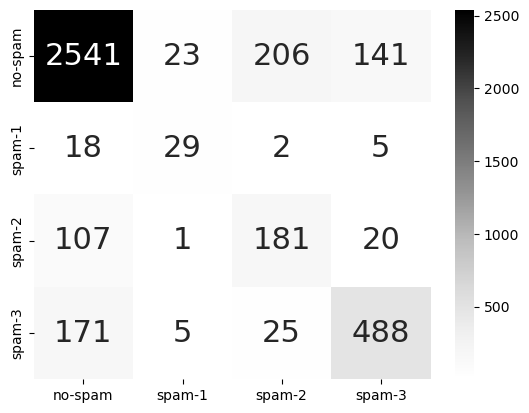

In [63]:
plotting_confusion_matrix(test_cm, task=2)


# BiLSTM - Cust Bias

## Task 1

In [64]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="BiLSTM_CustBias", task=1).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=1)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.6574 - Train Loss: 0.6224
Val Accuracy: 0.7476 - Val Loss: 0.4944
Validation loss decreased (inf --> 0.494366). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.7939 - Train Loss: 0.4509
Val Accuracy: 0.8099 - Val Loss: 0.4452
Validation loss decreased (0.494366 --> 0.445213). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.8280 - Train Loss: 0.3894
Val Accuracy: 0.8188 - Val Loss: 0.4567
EarlyStopping counter: 1 out of 10
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.8542 - Train Loss: 0.3384
Val Accuracy: 0.8320 - Val Loss: 0.4979
EarlyStopping counter: 2 out of 10
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.8773 - Train Loss: 0.2927
Val Accuracy: 0.8137 - Val Loss: 0.4837
EarlyStoppin

In [65]:
save_visualization_history(history, 'BiLSTM_CustBias', task=1)
plotting_history(history)


In [66]:
import os
import torch

model_name = "BiLSTM_CustBias"
model_path = os.path.join(model_name, f"{model_name}_best_model_(1).pth")
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8413
Precision: 0.8029
Recall: 0.7754
F1-score: 0.7872
Confusion matrix:
 [[2666  245]
 [ 384  668]]
              precision    recall  f1-score   support

           0     0.8741    0.9158    0.8945      2911
           1     0.7317    0.6350    0.6799      1052

    accuracy                         0.8413      3963
   macro avg     0.8029    0.7754    0.7872      3963
weighted avg     0.8363    0.8413    0.8375      3963



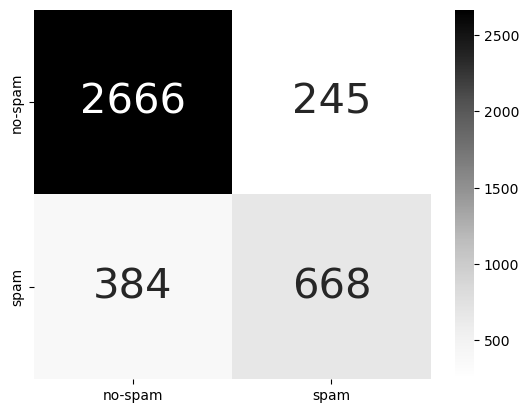

In [67]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [68]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="BiLSTM_CustBias", task=2).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=2)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.3500 - Train Loss: 1.2959
Val Accuracy: 0.3556 - Val Loss: 1.1504
Validation loss decreased (inf --> 1.150352). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.5654 - Train Loss: 0.9279
Val Accuracy: 0.6344 - Val Loss: 0.9528
Validation loss decreased (1.150352 --> 0.952808). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.6950 - Train Loss: 0.6827
Val Accuracy: 0.7023 - Val Loss: 0.9455
Validation loss decreased (0.952808 --> 0.945474). Saving model ...
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.7355 - Train Loss: 0.5749
Val Accuracy: 0.7055 - Val Loss: 0.9428
Validation loss decreased (0.945474 --> 0.942764). Saving model ...
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.7695 - Train

In [69]:
save_visualization_history(history, 'BiLSTM_CustBias', task=2)
plotting_history(history)


In [70]:
import os
import torch

model_name = "BiLSTM_CustBias"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.7959
Precision: 0.5947
Recall: 0.6590
F1-score: 0.6111
Confusion matrix:
 [[2515   41  243  112]
 [  17   29    4    4]
 [ 101    5  196    7]
 [ 222   16   37  414]]
              precision    recall  f1-score   support

           0     0.8809    0.8640    0.8724      2911
           1     0.3187    0.5370    0.4000        54
           2     0.4083    0.6343    0.4968       309
           3     0.7709    0.6009    0.6754       689

    accuracy                         0.7959      3963
   macro avg     0.5947    0.6590    0.6111      3963
weighted avg     0.8173    0.7959    0.8024      3963



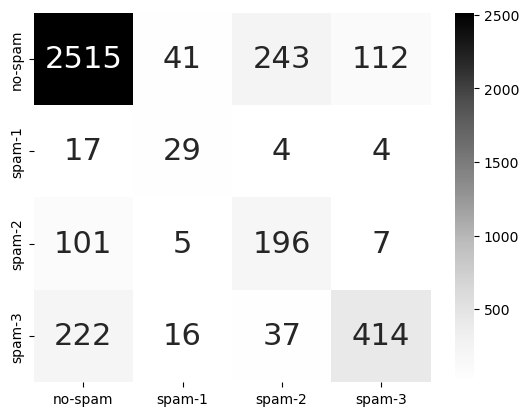

In [71]:
plotting_confusion_matrix(test_cm, task=2)


# BiLSTM - Basis Cust Bias

## Task 1

In [72]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="BiLSTM_BasisCustBias", task=1).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=1)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.6690 - Train Loss: 0.6198
Val Accuracy: 0.7432 - Val Loss: 0.5014
Validation loss decreased (inf --> 0.501415). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.7901 - Train Loss: 0.4552
Val Accuracy: 0.8081 - Val Loss: 0.4529
Validation loss decreased (0.501415 --> 0.452909). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.8328 - Train Loss: 0.3845
Val Accuracy: 0.8376 - Val Loss: 0.4739
EarlyStopping counter: 1 out of 10
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.8551 - Train Loss: 0.3342
Val Accuracy: 0.8269 - Val Loss: 0.4754
EarlyStopping counter: 2 out of 10
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.8794 - Train Loss: 0.2845
Val Accuracy: 0.8345 - Val Loss: 0.5354
EarlyStoppin

In [73]:
save_visualization_history(history, 'BiLSTM_BasisCustBias', task=1)
plotting_history(history)


In [74]:
import os
import torch

model_name = "BiLSTM_BasisCustBias"
model_path = os.path.join(model_name, f"{model_name}_best_model_(1).pth")
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8413
Precision: 0.8124
Recall: 0.7584
F1-score: 0.7785
Confusion matrix:
 [[2722  189]
 [ 440  612]]
              precision    recall  f1-score   support

           0     0.8608    0.9351    0.8964      2911
           1     0.7640    0.5817    0.6606      1052

    accuracy                         0.8413      3963
   macro avg     0.8124    0.7584    0.7785      3963
weighted avg     0.8352    0.8413    0.8338      3963



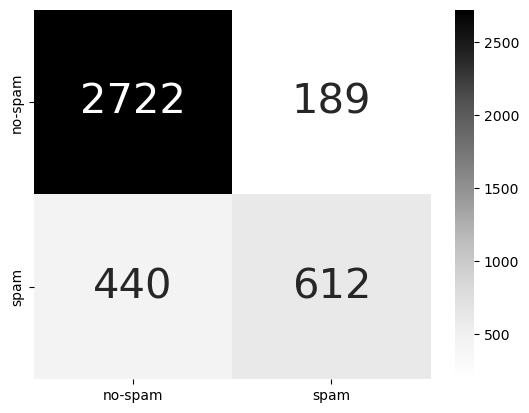

In [75]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [76]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="BiLSTM_BasisCustBias", task=2).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=2)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.4308 - Train Loss: 1.2871
Val Accuracy: 0.4802 - Val Loss: 1.1871
Validation loss decreased (inf --> 1.187109). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.5525 - Train Loss: 0.9193
Val Accuracy: 0.6532 - Val Loss: 1.0240
Validation loss decreased (1.187109 --> 1.024016). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.6860 - Train Loss: 0.6909
Val Accuracy: 0.6778 - Val Loss: 0.9763
Validation loss decreased (1.024016 --> 0.976344). Saving model ...
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.7237 - Train Loss: 0.5892
Val Accuracy: 0.7533 - Val Loss: 0.9848
EarlyStopping counter: 1 out of 10
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.7690 - Train Loss: 0.4824
Val Accuracy: 0.687

In [77]:
save_visualization_history(history, 'BiLSTM_BasisCustBias', task=2)
plotting_history(history)


In [78]:
import os
import torch

model_name = "BiLSTM_BasisCustBias"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.7820
Precision: 0.5898
Recall: 0.6737
F1-score: 0.6153
Confusion matrix:
 [[2411   34  319  147]
 [  16   29    6    3]
 [  84    2  209   14]
 [ 188   14   37  450]]
              precision    recall  f1-score   support

           0     0.8933    0.8282    0.8595      2911
           1     0.3671    0.5370    0.4361        54
           2     0.3660    0.6764    0.4750       309
           3     0.7329    0.6531    0.6907       689

    accuracy                         0.7820      3963
   macro avg     0.5898    0.6737    0.6153      3963
weighted avg     0.8171    0.7820    0.7944      3963



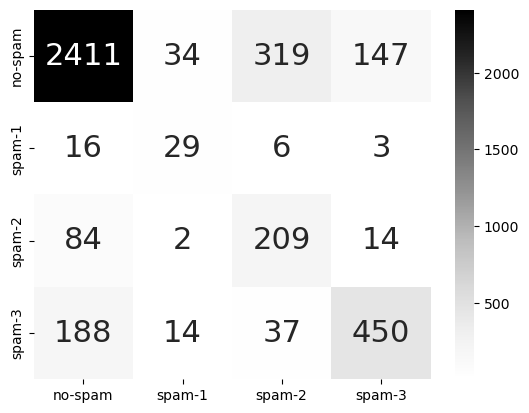

In [79]:
plotting_confusion_matrix(test_cm, task=2)


# BiLSTM - Cust Linear

## Task 1

In [80]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="BiLSTM_CustLinear", task=1).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=1)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.6423 - Train Loss: 0.6734
Val Accuracy: 0.7458 - Val Loss: 0.5458
Validation loss decreased (inf --> 0.545828). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.7630 - Train Loss: 0.5003
Val Accuracy: 0.7640 - Val Loss: 0.4819
Validation loss decreased (0.545828 --> 0.481941). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.8075 - Train Loss: 0.4314
Val Accuracy: 0.8238 - Val Loss: 0.4585
Validation loss decreased (0.481941 --> 0.458476). Saving model ...
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.8418 - Train Loss: 0.3735
Val Accuracy: 0.8143 - Val Loss: 0.4342
Validation loss decreased (0.458476 --> 0.434197). Saving model ...
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.8653 - Train

In [81]:
save_visualization_history(history, 'BiLSTM_CustLinear', task=1)
plotting_history(history)


In [82]:
import os
import torch

model_name = "BiLSTM_CustLinear"
model_path = os.path.join(model_name, f"{model_name}_best_model_(1).pth")
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8383
Precision: 0.7920
Recall: 0.7967
F1-score: 0.7943
Confusion matrix:
 [[2577  334]
 [ 307  745]]
              precision    recall  f1-score   support

           0     0.8936    0.8853    0.8894      2911
           1     0.6905    0.7082    0.6992      1052

    accuracy                         0.8383      3963
   macro avg     0.7920    0.7967    0.7943      3963
weighted avg     0.8396    0.8383    0.8389      3963



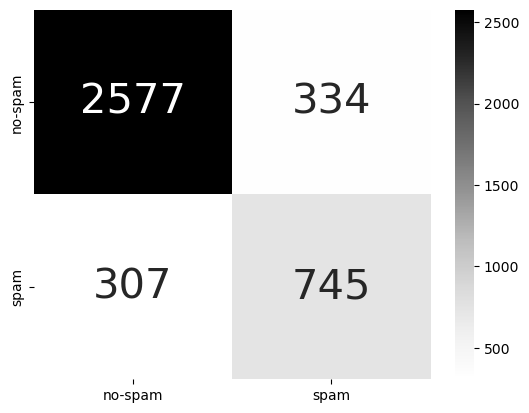

In [83]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [84]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="BiLSTM_CustLinear", task=2).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=2)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.3204 - Train Loss: 1.4092
Val Accuracy: 0.4871 - Val Loss: 1.2231
Validation loss decreased (inf --> 1.223126). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.4968 - Train Loss: 1.0669
Val Accuracy: 0.5387 - Val Loss: 1.1196
Validation loss decreased (1.223126 --> 1.119595). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.5836 - Train Loss: 0.8853
Val Accuracy: 0.6180 - Val Loss: 1.0253
Validation loss decreased (1.119595 --> 1.025331). Saving model ...
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.6677 - Train Loss: 0.7277
Val Accuracy: 0.6639 - Val Loss: 0.9888
Validation loss decreased (1.025331 --> 0.988837). Saving model ...
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.7186 - Train

In [85]:
save_visualization_history(history, 'BiLSTM_CustLinear', task=2)
plotting_history(history)


In [86]:
import os
import torch

model_name = "BiLSTM_CustLinear"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.7999
Precision: 0.5898
Recall: 0.6424
F1-score: 0.6110
Confusion matrix:
 [[2486   32  236  157]
 [  20   25    2    7]
 [ 123    2  166   18]
 [ 156   12   28  493]]
              precision    recall  f1-score   support

           0     0.8926    0.8540    0.8729      2911
           1     0.3521    0.4630    0.4000        54
           2     0.3843    0.5372    0.4480       309
           3     0.7304    0.7155    0.7229       689

    accuracy                         0.7999      3963
   macro avg     0.5898    0.6424    0.6110      3963
weighted avg     0.8174    0.7999    0.8072      3963



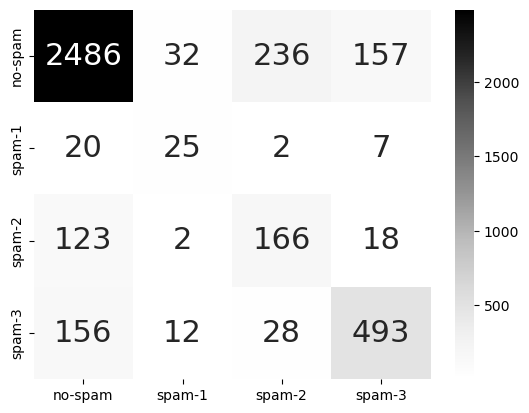

In [87]:
plotting_confusion_matrix(test_cm, task=2)


# BiLSTM - Basis Cust Linear

## Task 1

In [88]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="BiLSTM_BasisCustLinear", task=1).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=1)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.7307 - Train Loss: 0.5539
Val Accuracy: 0.8219 - Val Loss: 0.4511
Validation loss decreased (inf --> 0.451143). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.8051 - Train Loss: 0.4341
Val Accuracy: 0.7898 - Val Loss: 0.4287
Validation loss decreased (0.451143 --> 0.428722). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.8406 - Train Loss: 0.3682
Val Accuracy: 0.8263 - Val Loss: 0.4264
Validation loss decreased (0.428722 --> 0.426447). Saving model ...
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.8610 - Train Loss: 0.3175
Val Accuracy: 0.8383 - Val Loss: 0.4581
EarlyStopping counter: 1 out of 10
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.8841 - Train Loss: 0.2728
Val Accuracy: 0.834

In [89]:
save_visualization_history(history, 'BiLSTM_BasisCustLinear', task=1)
plotting_history(history)


In [90]:
import os
import torch

model_name="BiLSTM_BasisCustLinear"
model_path = os.path.join(model_name, f"{model_name}_best_model_(1).pth")
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8521
Precision: 0.8211
Recall: 0.7840
F1-score: 0.7993
Confusion matrix:
 [[2705  206]
 [ 380  672]]
              precision    recall  f1-score   support

           0     0.8768    0.9292    0.9023      2911
           1     0.7654    0.6388    0.6964      1052

    accuracy                         0.8521      3963
   macro avg     0.8211    0.7840    0.7993      3963
weighted avg     0.8472    0.8521    0.8476      3963



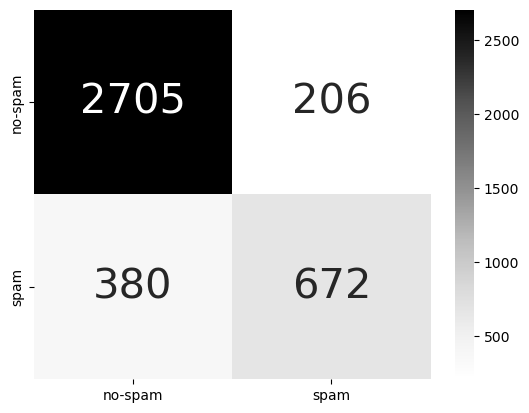

In [91]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [92]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="BiLSTM_BasisCustLinear", task=2).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=2)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.4802 - Train Loss: 1.1310
Val Accuracy: 0.5708 - Val Loss: 1.0570
Validation loss decreased (inf --> 1.056952). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.6294 - Train Loss: 0.7764
Val Accuracy: 0.6268 - Val Loss: 0.9916
Validation loss decreased (1.056952 --> 0.991577). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.7029 - Train Loss: 0.6443
Val Accuracy: 0.6941 - Val Loss: 0.8941
Validation loss decreased (0.991577 --> 0.894072). Saving model ...
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.7414 - Train Loss: 0.5394
Val Accuracy: 0.7231 - Val Loss: 0.9057
EarlyStopping counter: 1 out of 10
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.7756 - Train Loss: 0.4549
Val Accuracy: 0.758

In [93]:
save_visualization_history(history, 'BiLSTM_BasisCustLinear', task=2)
plotting_history(history)


In [94]:
import os
import torch

model_name="BiLSTM_BasisCustLinear"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.7974
Precision: 0.5862
Recall: 0.6971
F1-score: 0.6101
Confusion matrix:
 [[2456   65  302   88]
 [  18   32    3    1]
 [  82    3  211   13]
 [ 158   34   36  461]]
              precision    recall  f1-score   support

           0     0.9049    0.8437    0.8732      2911
           1     0.2388    0.5926    0.3404        54
           2     0.3822    0.6828    0.4901       309
           3     0.8188    0.6691    0.7364       689

    accuracy                         0.7974      3963
   macro avg     0.5862    0.6971    0.6101      3963
weighted avg     0.8401    0.7974    0.8123      3963



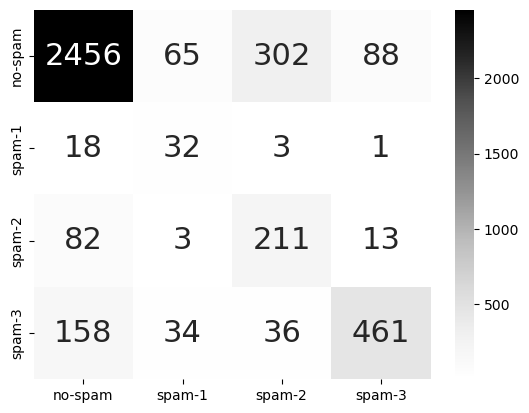

In [95]:
plotting_confusion_matrix(test_cm, task=2)


# BiLSTM - Cust Word Embedding

## Task 1

In [96]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="BiLSTM_CustWordEmbedding", task=1).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=1)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.6563 - Train Loss: 0.6503
Val Accuracy: 0.7004 - Val Loss: 0.5765
Validation loss decreased (inf --> 0.576462). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.7421 - Train Loss: 0.5354
Val Accuracy: 0.8181 - Val Loss: 0.5133
Validation loss decreased (0.576462 --> 0.513265). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.8249 - Train Loss: 0.4151
Val Accuracy: 0.8339 - Val Loss: 0.4822
Validation loss decreased (0.513265 --> 0.482188). Saving model ...
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.8690 - Train Loss: 0.3201
Val Accuracy: 0.8414 - Val Loss: 0.5951
EarlyStopping counter: 1 out of 10
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.9043 - Train Loss: 0.2444
Val Accuracy: 0.829

In [97]:
save_visualization_history(history, 'BiLSTM_CustWordEmbedding', task=1)
plotting_history(history)


In [98]:
import os
import torch

model_name="BiLSTM_CustWordEmbedding"
model_path = os.path.join(model_name, f"{model_name}_best_model_(1).pth")
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8330
Precision: 0.8055
Recall: 0.7394
F1-score: 0.7619
Confusion matrix:
 [[2733  178]
 [ 484  568]]
              precision    recall  f1-score   support

           0     0.8495    0.9389    0.8920      2911
           1     0.7614    0.5399    0.6318      1052

    accuracy                         0.8330      3963
   macro avg     0.8055    0.7394    0.7619      3963
weighted avg     0.8261    0.8330    0.8229      3963



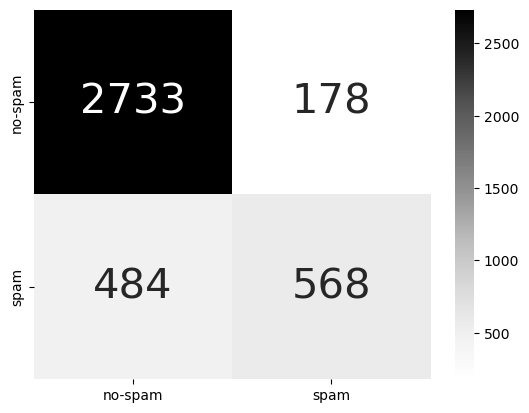

In [99]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [100]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="BiLSTM_CustWordEmbedding", task=2).to(device)
print(model)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=2)


Loaded pretrained embeddings, weights are not trainable.
ViSpam_Classifier(
  (embedding): CustWordEmbedding(
    (embedding): Embedding(15359, 300, padding_idx=0)
    (category_id): Embedding(12, 90000)
  )
  (spatial_dropout1d): Dropout2d(p=0.5, inplace=False)
  (network): BiLSTM(
    (lstm): LSTM(300, 64, batch_first=True, bidirectional=True)
  )
  (W): BasicLinear(
    (W): Linear(in_features=256, out_features=4, bias=False)
  )
  (bias): BasicBias()
)
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.3472 - Train Loss: 1.3259
Val Accuracy: 0.4267 - Val Loss: 1.2670
Validation loss decreased (inf --> 1.267046). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.4275 - Train Loss: 1.1378
Val Accuracy: 0.5104 - Val Loss: 1.1899
Validation loss decreased (1.267046 --> 1.189916). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.5293 - Train Loss: 0.9432
Val Accura

In [101]:
save_visualization_history(history, 'BiLSTM_CustWordEmbedding', task=2)
plotting_history(history)


In [102]:
import os
import torch

model_name="BiLSTM_CustWordEmbedding"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.7562
Precision: 0.5867
Recall: 0.6221
F1-score: 0.5715
Confusion matrix:
 [[2410   36  408   57]
 [  21   25    6    2]
 [  89    3  214    3]
 [ 253   13   75  348]]
              precision    recall  f1-score   support

           0     0.8691    0.8279    0.8480      2911
           1     0.3247    0.4630    0.3817        54
           2     0.3044    0.6926    0.4229       309
           3     0.8488    0.5051    0.6333       689

    accuracy                         0.7562      3963
   macro avg     0.5867    0.6221    0.5715      3963
weighted avg     0.8141    0.7562    0.7712      3963



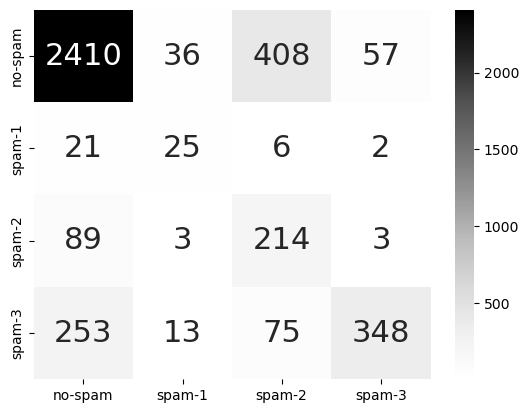

In [103]:
plotting_confusion_matrix(test_cm, task=2)


# BiLSTM - Basis Cust Word Embedding

## Task 1

In [104]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="BiLSTM_BasisCustWordEmbedding", task=1).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=1)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.7724 - Train Loss: 0.5762
Val Accuracy: 0.8282 - Val Loss: 0.4759
Validation loss decreased (inf --> 0.475941). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.8262 - Train Loss: 0.4095
Val Accuracy: 0.8068 - Val Loss: 0.4526
Validation loss decreased (0.475941 --> 0.452645). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.8717 - Train Loss: 0.3160
Val Accuracy: 0.8269 - Val Loss: 0.4778
EarlyStopping counter: 1 out of 10
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.9070 - Train Loss: 0.2395
Val Accuracy: 0.8383 - Val Loss: 0.5126
EarlyStopping counter: 2 out of 10
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.9303 - Train Loss: 0.1846
Val Accuracy: 0.8332 - Val Loss: 0.6351
EarlyStoppin

In [105]:
save_visualization_history(history, 'BiLSTM_BasisCustWordEmbedding', task=1)
plotting_history(history)


In [106]:
import os
import torch

model_name="BiLSTM_BasisCustWordEmbedding"
model_path = os.path.join(model_name, f"{model_name}_best_model_(1).pth")
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8390
Precision: 0.7958
Recall: 0.7836
F1-score: 0.7893
Confusion matrix:
 [[2625  286]
 [ 352  700]]
              precision    recall  f1-score   support

           0     0.8818    0.9018    0.8916      2911
           1     0.7099    0.6654    0.6869      1052

    accuracy                         0.8390      3963
   macro avg     0.7958    0.7836    0.7893      3963
weighted avg     0.8361    0.8390    0.8373      3963



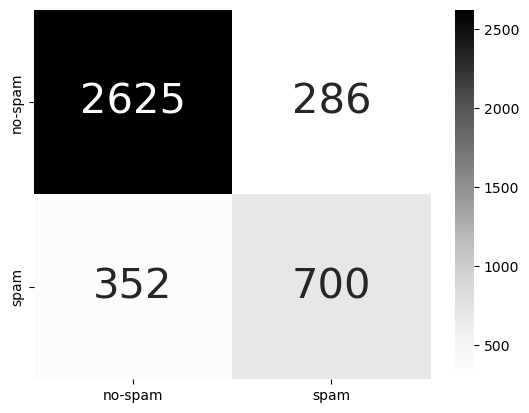

In [107]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [108]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="BiLSTM_BasisCustWordEmbedding", task=2).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=2)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.4523 - Train Loss: 1.1870
Val Accuracy: 0.5035 - Val Loss: 1.0663
Validation loss decreased (inf --> 1.066267). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.6391 - Train Loss: 0.7806
Val Accuracy: 0.7143 - Val Loss: 0.9748
Validation loss decreased (1.066267 --> 0.974815). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.7371 - Train Loss: 0.5510
Val Accuracy: 0.7231 - Val Loss: 0.9613
Validation loss decreased (0.974815 --> 0.961335). Saving model ...
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.7931 - Train Loss: 0.4189
Val Accuracy: 0.7709 - Val Loss: 1.1029
EarlyStopping counter: 1 out of 10
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.8360 - Train Loss: 0.3261
Val Accuracy: 0.755

In [109]:
save_visualization_history(history, 'BiLSTM_BasisCustWordEmbedding', task=2)
plotting_history(history)


In [110]:
import os
import torch

model_name="BiLSTM_BasisCustWordEmbedding"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.7903
Precision: 0.6029
Recall: 0.6603
F1-score: 0.6225
Confusion matrix:
 [[2467   31  265  148]
 [  17   29    5    3]
 [ 105    0  187   17]
 [ 191    9   40  449]]
              precision    recall  f1-score   support

           0     0.8874    0.8475    0.8670      2911
           1     0.4203    0.5370    0.4715        54
           2     0.3763    0.6052    0.4640       309
           3     0.7277    0.6517    0.6876       689

    accuracy                         0.7903      3963
   macro avg     0.6029    0.6603    0.6225      3963
weighted avg     0.8134    0.7903    0.7990      3963



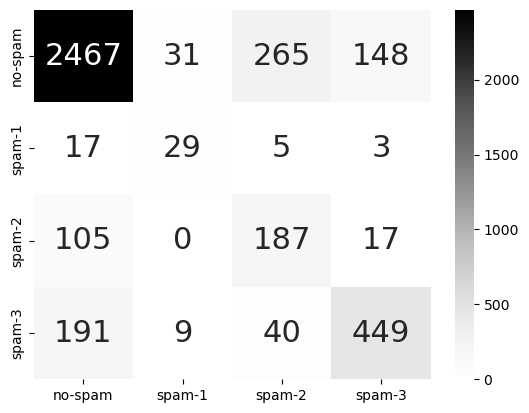

In [111]:
plotting_confusion_matrix(test_cm, task=2)


# BiGRU - Cust Bias

## Task 1

In [112]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="BiGRU_CustBias", task=1).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=1)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.6767 - Train Loss: 0.6012
Val Accuracy: 0.8062 - Val Loss: 0.4684
Validation loss decreased (inf --> 0.468414). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.8001 - Train Loss: 0.4480
Val Accuracy: 0.8288 - Val Loss: 0.4444
Validation loss decreased (0.468414 --> 0.444385). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.8311 - Train Loss: 0.3841
Val Accuracy: 0.8307 - Val Loss: 0.4305
Validation loss decreased (0.444385 --> 0.430519). Saving model ...
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.8588 - Train Loss: 0.3281
Val Accuracy: 0.8326 - Val Loss: 0.4376
EarlyStopping counter: 1 out of 10
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.8845 - Train Loss: 0.2793
Val Accuracy: 0.799

In [113]:
save_visualization_history(history, 'BiGRU_CustBias', task=1)
plotting_history(history)


In [114]:
import os
import torch

model_name="BiGRU_CustBias"
model_path = os.path.join(model_name, f"{model_name}_best_model_(1).pth")
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8428
Precision: 0.7980
Recall: 0.8007
F1-score: 0.7994
Confusion matrix:
 [[2592  319]
 [ 304  748]]
              precision    recall  f1-score   support

           0     0.8950    0.8904    0.8927      2911
           1     0.7010    0.7110    0.7060      1052

    accuracy                         0.8428      3963
   macro avg     0.7980    0.8007    0.7994      3963
weighted avg     0.8435    0.8428    0.8431      3963



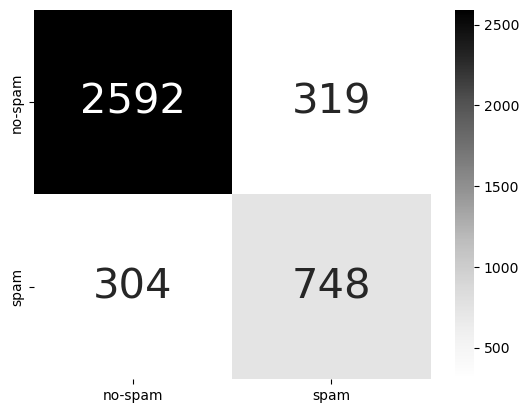

In [115]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [116]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="BiGRU_CustBias", task=2).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=2)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.3769 - Train Loss: 1.2678
Val Accuracy: 0.5129 - Val Loss: 1.1545
Validation loss decreased (inf --> 1.154493). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.5673 - Train Loss: 0.8938
Val Accuracy: 0.6256 - Val Loss: 0.9563
Validation loss decreased (1.154493 --> 0.956289). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.6838 - Train Loss: 0.6773
Val Accuracy: 0.6702 - Val Loss: 0.8873
Validation loss decreased (0.956289 --> 0.887273). Saving model ...
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.7403 - Train Loss: 0.5602
Val Accuracy: 0.7344 - Val Loss: 0.9538
EarlyStopping counter: 1 out of 10
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.7821 - Train Loss: 0.4708
Val Accuracy: 0.741

In [117]:
save_visualization_history(history, 'BiGRU_CustBias', task=2)
plotting_history(history)


In [118]:
import os
import torch

model_name="BiGRU_CustBias"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.7716
Precision: 0.5577
Recall: 0.6520
F1-score: 0.5729
Confusion matrix:
 [[2434   74  299  104]
 [  17   29    4    4]
 [  83    5  208   13]
 [ 231   28   43  387]]
              precision    recall  f1-score   support

           0     0.8803    0.8361    0.8576      2911
           1     0.2132    0.5370    0.3053        54
           2     0.3755    0.6731    0.4820       309
           3     0.7618    0.5617    0.6466       689

    accuracy                         0.7716      3963
   macro avg     0.5577    0.6520    0.5729      3963
weighted avg     0.8112    0.7716    0.7841      3963



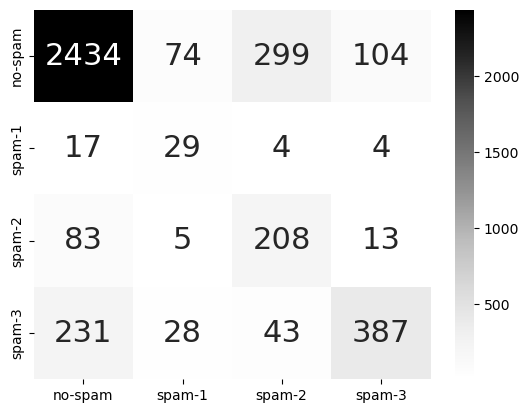

In [119]:
plotting_confusion_matrix(test_cm, task=2)


# BiGRU - Basis Cust Bias

## Task 1

In [120]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="BiGRU_BasisCustBias", task=1).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=1)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.7140 - Train Loss: 0.5944
Val Accuracy: 0.7671 - Val Loss: 0.4800
Validation loss decreased (inf --> 0.480011). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.8005 - Train Loss: 0.4410
Val Accuracy: 0.8244 - Val Loss: 0.4392
Validation loss decreased (0.480011 --> 0.439210). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.8354 - Train Loss: 0.3821
Val Accuracy: 0.8232 - Val Loss: 0.4425
EarlyStopping counter: 1 out of 10
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.8618 - Train Loss: 0.3295
Val Accuracy: 0.8282 - Val Loss: 0.4507
EarlyStopping counter: 2 out of 10
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.8831 - Train Loss: 0.2790
Val Accuracy: 0.8395 - Val Loss: 0.4691
EarlyStoppin

In [121]:
save_visualization_history(history, 'BiGRU_BasisCustBias', task=1)
plotting_history(history)


In [122]:
import os
import torch

model_name="BiGRU_BasisCustBias"
model_path = os.path.join(model_name, f"{model_name}_best_model_(1).pth")
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8458
Precision: 0.8058
Recall: 0.7897
F1-score: 0.7971
Confusion matrix:
 [[2647  264]
 [ 347  705]]
              precision    recall  f1-score   support

           0     0.8841    0.9093    0.8965      2911
           1     0.7276    0.6702    0.6977      1052

    accuracy                         0.8458      3963
   macro avg     0.8058    0.7897    0.7971      3963
weighted avg     0.8425    0.8458    0.8437      3963



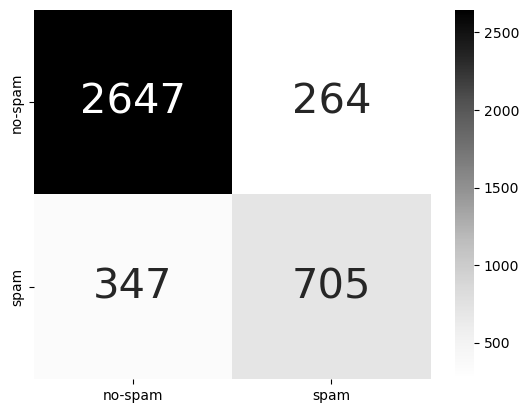

In [123]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [124]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="BiGRU_BasisCustBias", task=2).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=2)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.4918 - Train Loss: 1.2595
Val Accuracy: 0.5884 - Val Loss: 1.1712
Validation loss decreased (inf --> 1.171167). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.5655 - Train Loss: 0.8987
Val Accuracy: 0.5645 - Val Loss: 0.9984
Validation loss decreased (1.171167 --> 0.998356). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.6718 - Train Loss: 0.6950
Val Accuracy: 0.6879 - Val Loss: 0.9291
Validation loss decreased (0.998356 --> 0.929051). Saving model ...
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.7331 - Train Loss: 0.5562
Val Accuracy: 0.7244 - Val Loss: 0.9355
EarlyStopping counter: 1 out of 10
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.7745 - Train Loss: 0.4629
Val Accuracy: 0.741

In [125]:
save_visualization_history(history, 'BiGRU_BasisCustBias', task=2)
plotting_history(history)


In [126]:
import os
import torch

model_name="BiGRU_BasisCustBias"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.7777
Precision: 0.5760
Recall: 0.6715
F1-score: 0.5950
Confusion matrix:
 [[2421   59  334   97]
 [  16   31    4    3]
 [  91    3  205   10]
 [ 195   20   49  425]]
              precision    recall  f1-score   support

           0     0.8891    0.8317    0.8594      2911
           1     0.2743    0.5741    0.3713        54
           2     0.3463    0.6634    0.4550       309
           3     0.7944    0.6168    0.6944       689

    accuracy                         0.7777      3963
   macro avg     0.5760    0.6715    0.5950      3963
weighted avg     0.8219    0.7777    0.7926      3963



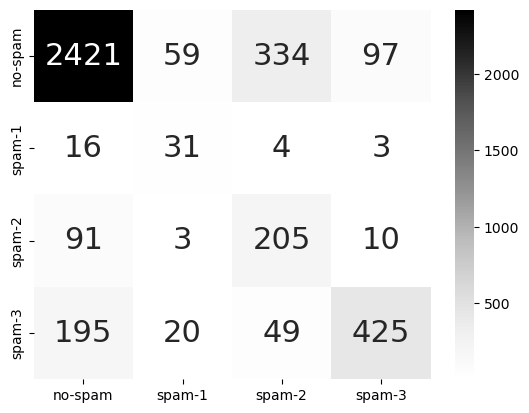

In [127]:
plotting_confusion_matrix(test_cm, task=2)


# BiGRU - Cust Linear

## Task 1

In [128]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="BiGRU_CustLinear", task=1).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=1)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.6008 - Train Loss: 0.7923
Val Accuracy: 0.6828 - Val Loss: 0.6177
Validation loss decreased (inf --> 0.617668). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.7340 - Train Loss: 0.5448
Val Accuracy: 0.7596 - Val Loss: 0.5203
Validation loss decreased (0.617668 --> 0.520259). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.7967 - Train Loss: 0.4393
Val Accuracy: 0.8112 - Val Loss: 0.4980
Validation loss decreased (0.520259 --> 0.497975). Saving model ...
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.8294 - Train Loss: 0.3774
Val Accuracy: 0.7961 - Val Loss: 0.4886
Validation loss decreased (0.497975 --> 0.488551). Saving model ...
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.8636 - Train

In [129]:
save_visualization_history(history, 'BiGRU_CustLinear', task=1)
plotting_history(history)


In [130]:
import os
import torch

model_name="BiGRU_CustLinear"
model_path = os.path.join(model_name, f"{model_name}_best_model_(1).pth")
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8264
Precision: 0.7798
Recall: 0.7638
F1-score: 0.7710
Confusion matrix:
 [[2612  299]
 [ 389  663]]
              precision    recall  f1-score   support

           0     0.8704    0.8973    0.8836      2911
           1     0.6892    0.6302    0.6584      1052

    accuracy                         0.8264      3963
   macro avg     0.7798    0.7638    0.7710      3963
weighted avg     0.8223    0.8264    0.8238      3963



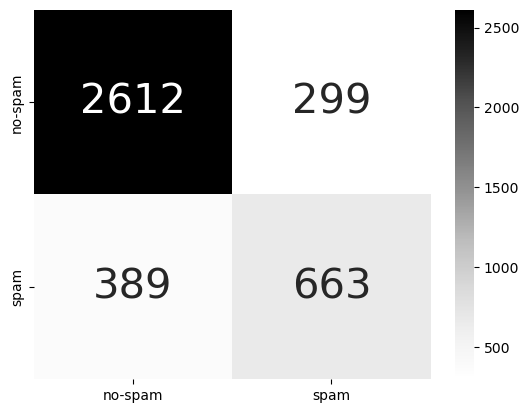

In [131]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [132]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="BiGRU_CustLinear", task=2, hidden_size=64, drop=0.5, spatial_dropout=True, mode='static').to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=2)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.3235 - Train Loss: 1.7160
Val Accuracy: 0.4965 - Val Loss: 1.3385
Validation loss decreased (inf --> 1.338453). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.4992 - Train Loss: 1.0823
Val Accuracy: 0.5897 - Val Loss: 1.1817
Validation loss decreased (1.338453 --> 1.181739). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.5795 - Train Loss: 0.8653
Val Accuracy: 0.6388 - Val Loss: 1.1398
Validation loss decreased (1.181739 --> 1.139792). Saving model ...
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.6755 - Train Loss: 0.6944
Val Accuracy: 0.6602 - Val Loss: 1.0833
Validation loss decreased (1.139792 --> 1.083259). Saving model ...
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.7081 - Train

In [133]:
save_visualization_history(history, 'BiGRU_CustLinear', task=2)
plotting_history(history)


In [134]:
import os
import torch

model_name="BiGRU_CustLinear"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.7724
Precision: 0.5626
Recall: 0.6409
F1-score: 0.5822
Confusion matrix:
 [[2405   44  330  132]
 [  20   25    4    5]
 [  97    1  201   10]
 [ 186   21   52  430]]
              precision    recall  f1-score   support

           0     0.8881    0.8262    0.8560      2911
           1     0.2747    0.4630    0.3448        54
           2     0.3424    0.6505    0.4487       309
           3     0.7452    0.6241    0.6793       689

    accuracy                         0.7724      3963
   macro avg     0.5626    0.6409    0.5822      3963
weighted avg     0.8124    0.7724    0.7866      3963



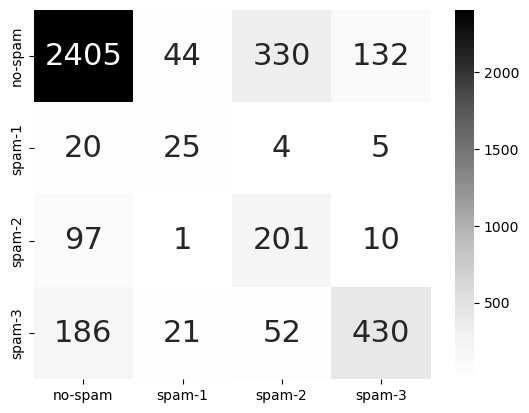

In [135]:
plotting_confusion_matrix(test_cm, task=2)


# BiGRU - Basis Cust Linear

## Task 1

In [136]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="BiGRU_BasisCustLinear", task=1).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=1)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.7090 - Train Loss: 0.5748
Val Accuracy: 0.8307 - Val Loss: 0.4554
Validation loss decreased (inf --> 0.455394). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.8037 - Train Loss: 0.4377
Val Accuracy: 0.8125 - Val Loss: 0.4174
Validation loss decreased (0.455394 --> 0.417447). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.8369 - Train Loss: 0.3787
Val Accuracy: 0.8049 - Val Loss: 0.4123
Validation loss decreased (0.417447 --> 0.412348). Saving model ...
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.8563 - Train Loss: 0.3306
Val Accuracy: 0.8307 - Val Loss: 0.4009
Validation loss decreased (0.412348 --> 0.400906). Saving model ...
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.8829 - Train

In [137]:
save_visualization_history(history, 'BiGRU_BasisCustLinear', task=1)
plotting_history(history)


In [138]:
import os
import torch

model_name="BiGRU_BasisCustLinear"
model_path = os.path.join(model_name, f"{model_name}_best_model_(1).pth")
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8483
Precision: 0.8046
Recall: 0.8106
F1-score: 0.8075
Confusion matrix:
 [[2594  317]
 [ 284  768]]
              precision    recall  f1-score   support

           0     0.9013    0.8911    0.8962      2911
           1     0.7078    0.7300    0.7188      1052

    accuracy                         0.8483      3963
   macro avg     0.8046    0.8106    0.8075      3963
weighted avg     0.8500    0.8483    0.8491      3963



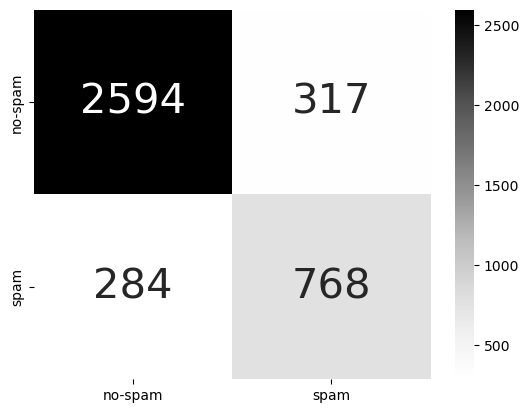

In [139]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [140]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="BiGRU_BasisCustLinear", task=2).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=2)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.4791 - Train Loss: 1.0740
Val Accuracy: 0.5488 - Val Loss: 1.0143
Validation loss decreased (inf --> 1.014293). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.6446 - Train Loss: 0.7565
Val Accuracy: 0.6186 - Val Loss: 0.9248
Validation loss decreased (1.014293 --> 0.924786). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.7017 - Train Loss: 0.6363
Val Accuracy: 0.7086 - Val Loss: 0.8929
Validation loss decreased (0.924786 --> 0.892872). Saving model ...
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.7504 - Train Loss: 0.5297
Val Accuracy: 0.7074 - Val Loss: 0.9061
EarlyStopping counter: 1 out of 10
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.7774 - Train Loss: 0.4557
Val Accuracy: 0.794

In [141]:
save_visualization_history(history, 'BiGRU_BasisCustLinear', task=2)
plotting_history(history)


In [142]:
import os
import torch

model_name="BiGRU_BasisCustLinear"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.7981
Precision: 0.6179
Recall: 0.6892
F1-score: 0.6433
Confusion matrix:
 [[2418   26  311  156]
 [  20   29    2    3]
 [  92    1  196   20]
 [ 137    8   24  520]]
              precision    recall  f1-score   support

           0     0.9066    0.8306    0.8670      2911
           1     0.4531    0.5370    0.4915        54
           2     0.3677    0.6343    0.4656       309
           3     0.7439    0.7547    0.7493       689

    accuracy                         0.7981      3963
   macro avg     0.6179    0.6892    0.6433      3963
weighted avg     0.8301    0.7981    0.8101      3963



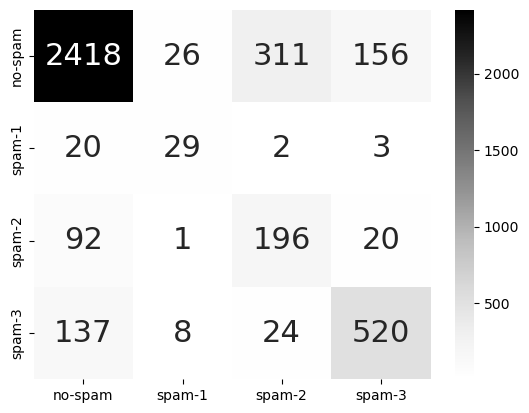

In [143]:
plotting_confusion_matrix(test_cm, task=2)


# BiGRU - Cust Word Embedding

## Task 1

In [144]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="BiGRU_CustWordEmbedding", task=1).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=1)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.6482 - Train Loss: 0.6500
Val Accuracy: 0.6872 - Val Loss: 0.5752
Validation loss decreased (inf --> 0.575198). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.7716 - Train Loss: 0.5292
Val Accuracy: 0.8288 - Val Loss: 0.5054
Validation loss decreased (0.575198 --> 0.505407). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.8342 - Train Loss: 0.4096
Val Accuracy: 0.8408 - Val Loss: 0.5059
EarlyStopping counter: 1 out of 10
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.8822 - Train Loss: 0.3078
Val Accuracy: 0.8376 - Val Loss: 0.5660
EarlyStopping counter: 2 out of 10
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.9123 - Train Loss: 0.2320
Val Accuracy: 0.8389 - Val Loss: 0.6231
EarlyStoppin

In [145]:
save_visualization_history(history, 'BiGRU_CustWordEmbedding', task=1)
plotting_history(history)


In [146]:
import os
import torch

model_name="BiGRU_CustWordEmbedding"
model_path = os.path.join(model_name, f"{model_name}_best_model_(1).pth")
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8246
Precision: 0.7820
Recall: 0.7468
F1-score: 0.7609
Confusion matrix:
 [[2657  254]
 [ 441  611]]
              precision    recall  f1-score   support

           0     0.8577    0.9127    0.8843      2911
           1     0.7064    0.5808    0.6375      1052

    accuracy                         0.8246      3963
   macro avg     0.7820    0.7468    0.7609      3963
weighted avg     0.8175    0.8246    0.8188      3963



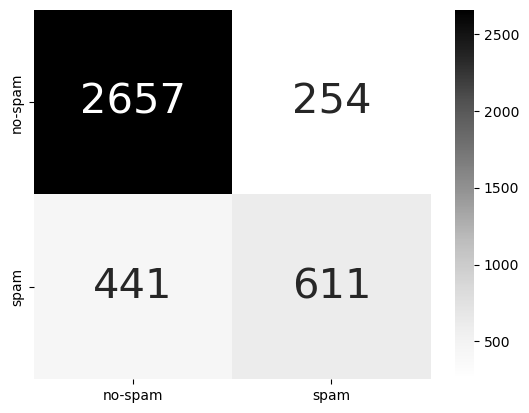

In [147]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [148]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="BiGRU_CustWordEmbedding", task=2).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=2)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.3449 - Train Loss: 1.3281
Val Accuracy: 0.4947 - Val Loss: 1.3059
Validation loss decreased (inf --> 1.305894). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.4409 - Train Loss: 1.1483
Val Accuracy: 0.4430 - Val Loss: 1.1718
Validation loss decreased (1.305894 --> 1.171829). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.5367 - Train Loss: 0.9380
Val Accuracy: 0.5872 - Val Loss: 1.0389
Validation loss decreased (1.171829 --> 1.038901). Saving model ...
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.6752 - Train Loss: 0.6951
Val Accuracy: 0.6595 - Val Loss: 0.9811
Validation loss decreased (1.038901 --> 0.981126). Saving model ...
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.7468 - Train

In [149]:
save_visualization_history(history, 'BiGRU_CustWordEmbedding', task=2)
plotting_history(history)


In [150]:
import os
import torch

model_name="BiGRU_CustWordEmbedding"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.7673
Precision: 0.5566
Recall: 0.5964
F1-score: 0.5619
Confusion matrix:
 [[2462   35  295  119]
 [  23   23    6    2]
 [ 125    2  172   10]
 [ 222   19   64  384]]
              precision    recall  f1-score   support

           0     0.8694    0.8458    0.8574      2911
           1     0.2911    0.4259    0.3459        54
           2     0.3203    0.5566    0.4066       309
           3     0.7456    0.5573    0.6379       689

    accuracy                         0.7673      3963
   macro avg     0.5566    0.5964    0.5619      3963
weighted avg     0.7972    0.7673    0.7771      3963



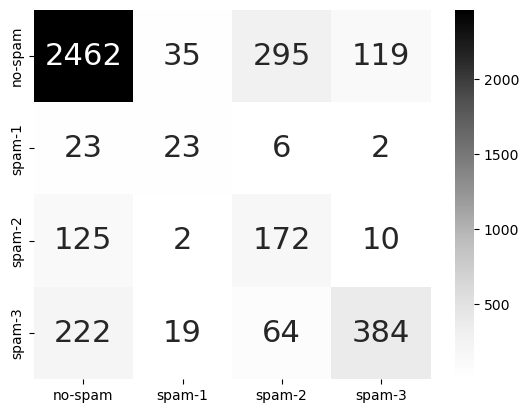

In [151]:
plotting_confusion_matrix(test_cm, task=2)


# BiGRU - Basis Cust Word Embedding

## Task 1

In [152]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="BiGRU_BasisCustWordEmbedding", task=1).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=1)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.7764 - Train Loss: 0.5701
Val Accuracy: 0.8194 - Val Loss: 0.4894
Validation loss decreased (inf --> 0.489409). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.8292 - Train Loss: 0.4048
Val Accuracy: 0.8188 - Val Loss: 0.4469
Validation loss decreased (0.489409 --> 0.446925). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.8792 - Train Loss: 0.3017
Val Accuracy: 0.8250 - Val Loss: 0.4852
EarlyStopping counter: 1 out of 10
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.9130 - Train Loss: 0.2258
Val Accuracy: 0.8250 - Val Loss: 0.5638
EarlyStopping counter: 2 out of 10
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.9333 - Train Loss: 0.1775
Val Accuracy: 0.7999 - Val Loss: 0.6434
EarlyStoppin

In [153]:
save_visualization_history(history, 'BiGRU_BasisCustWordEmbedding', task=1)
plotting_history(history)


In [154]:
import os
import torch

model_name="BiGRU_BasisCustWordEmbedding"
model_path = os.path.join(model_name, f"{model_name}_best_model_(1).pth")
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8292
Precision: 0.7803
Recall: 0.7887
F1-score: 0.7843
Confusion matrix:
 [[2547  364]
 [ 313  739]]
              precision    recall  f1-score   support

           0     0.8906    0.8750    0.8827      2911
           1     0.6700    0.7025    0.6858      1052

    accuracy                         0.8292      3963
   macro avg     0.7803    0.7887    0.7843      3963
weighted avg     0.8320    0.8292    0.8304      3963



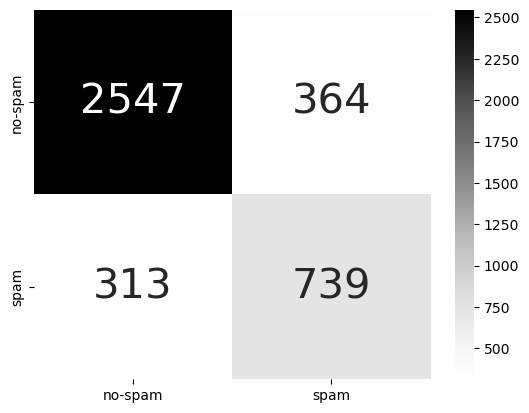

In [155]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [156]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="BiGRU_BasisCustWordEmbedding", task=2).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=2)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.4329 - Train Loss: 1.1807
Val Accuracy: 0.6784 - Val Loss: 1.0787
Validation loss decreased (inf --> 1.078690). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.6530 - Train Loss: 0.7879
Val Accuracy: 0.7067 - Val Loss: 0.9569
Validation loss decreased (1.078690 --> 0.956869). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.7548 - Train Loss: 0.5371
Val Accuracy: 0.7388 - Val Loss: 0.9867
EarlyStopping counter: 1 out of 10
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.8169 - Train Loss: 0.3889
Val Accuracy: 0.7709 - Val Loss: 1.0606
EarlyStopping counter: 2 out of 10
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.8578 - Train Loss: 0.2844
Val Accuracy: 0.7432 - Val Loss: 1.1452
EarlyStoppin

In [157]:
save_visualization_history(history, 'BiGRU_BasisCustWordEmbedding', task=2)
plotting_history(history)


In [158]:
import os
import torch

model_name="BiGRU_BasisCustWordEmbedding"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.7853
Precision: 0.5995
Recall: 0.6611
F1-score: 0.6218
Confusion matrix:
 [[2447   29  267  168]
 [  17   30    4    3]
 [ 108    0  183   18]
 [ 189   10   38  452]]
              precision    recall  f1-score   support

           0     0.8863    0.8406    0.8628      2911
           1     0.4348    0.5556    0.4878        54
           2     0.3720    0.5922    0.4569       309
           3     0.7051    0.6560    0.6797       689

    accuracy                         0.7853      3963
   macro avg     0.5995    0.6611    0.6218      3963
weighted avg     0.8085    0.7853    0.7942      3963



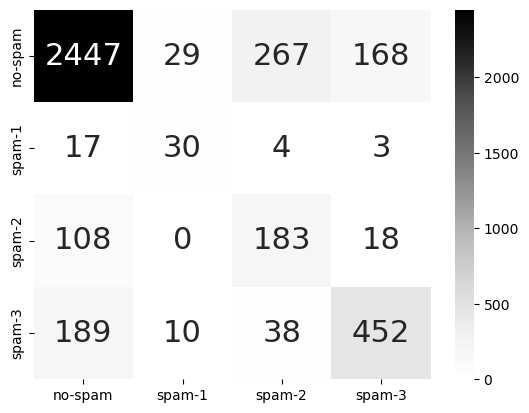

In [159]:
plotting_confusion_matrix(test_cm, task=2)
